# Task 1 - Dimensionality reduction and binary classification

## Data Source

 * The data source consists of the files `train.csv` and `evaluate.csv`.
 * These are 28x28 pixel grayscale images obtained from the [Fashion Mnist dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * The `train.csv` file contains training data.
 * The target variable is named **label**.
 * The `evaluate.csv` file contains testing data without actual label values.


## Instructions for project development

**Assignment Instructions**:
  * In the notebook, load data from the `train.csv` file. Divide it into subsets that will be used for training, model comparison, and subsequent prediction of the final model's performance.
  * Perform basic data exploration and discuss your observations. Also, display some graphs and images.
  * Apply the **SVM**, **Naive Bayes classifier**, and **LDA** models step by step, and for each of them:
      * Comment on the suitability of the model for the given task.
      * Select the main hyperparameters to tune (if the model has hyperparameters) and find their best values.
      * Experiment with data standardization/normalization.
      * For SVM, try at least two different kernel functions.
      * Always provide proper comments on the obtained results.

  * Apply dimensionality reduction methods PCA and LLE gradually, and for each of them:
      * Repeat the previous steps and attempt to improve the models.
      * Investigate which dimension is best in terms of the final model's performance.
      * Always provide proper comments on the obtained results.

  * From all the tested options, select the final model and estimate the accuracy you can expect on new data that you have not had access to so far.

  * Finally, load the evaluation data from the `evaluate.csv` file. Use the final model to calculate predictions for this data (the explained variable is no longer present). Create a `results.csv` file in which you save the obtained predictions in two columns: **ID**, **label prediction**. Submit this file as well (save it in the project alongside the notebook).

   * Example of the first lines of the `results.csv` file:

  
```
ID,label
0,0
1,1
...
```

## Let's Start

### Getting to know the data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
import sklearn.metrics as metrics

In [2]:
data = pd.read_csv("train.csv")

In [3]:
print(f"Data dimensions: {data.shape}")
print(f"Amount of unique values of target variable: {data['label'].nunique()}")
print(f"Unique values of target variable: {data['label'].unique()}")
print(f"Data types of all variables:\n{data.dtypes.value_counts().to_string(index=True, name=False)}")
display(data.head(10))

Data dimensions: (2400, 785)
Amount of unique values of target variable: 2
Unique values of target variable: [1 0]
Data types of all variables:
int64    785


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,2,1,4,2,0,0,...,37,73,65,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,105,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,135,135,184,59,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,70,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,103,0,0,0,0,0,0,0,0,0
6,0,0,0,3,0,1,1,1,1,0,...,94,46,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,42,161,...,158,160,114,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see, we have two unique values of the target variable, which means that we are going to build a `binary classification model`. 

We should also note that we have a large number of features, which means we will need to take care of the `curse of dimensionality`. 

Fortunately, we only have `numeric features`, so we won't need to deal with data preprocessing.

Checking whether there are any `null values` in our data.

In [4]:
data.columns[data.isnull().any()]

Index([], dtype='object')

There are no null values present in our data. Remove possible `duplicates` from the table.

In [5]:
data.drop_duplicates(inplace=True)
data.shape 

(2400, 785)

### Analyzing the data

Dividing the data into `features` and `target variable`.

In [6]:
features = data.drop("label", axis=1)
target_var = data["label"]

Of all possible statistical metrics that can help us analyze the data we have, for this dataset I consider analysis based on the `number of unique values` and `variance` to be the most appropriate. Feautures with a small number of unique values will be almost constant, which means they will be discarded to solve the `curse of dimensionality` as they do not carry a lot of information. The same applies to variance, which in theory will be even better at identifying features that do not carry a lot of information.

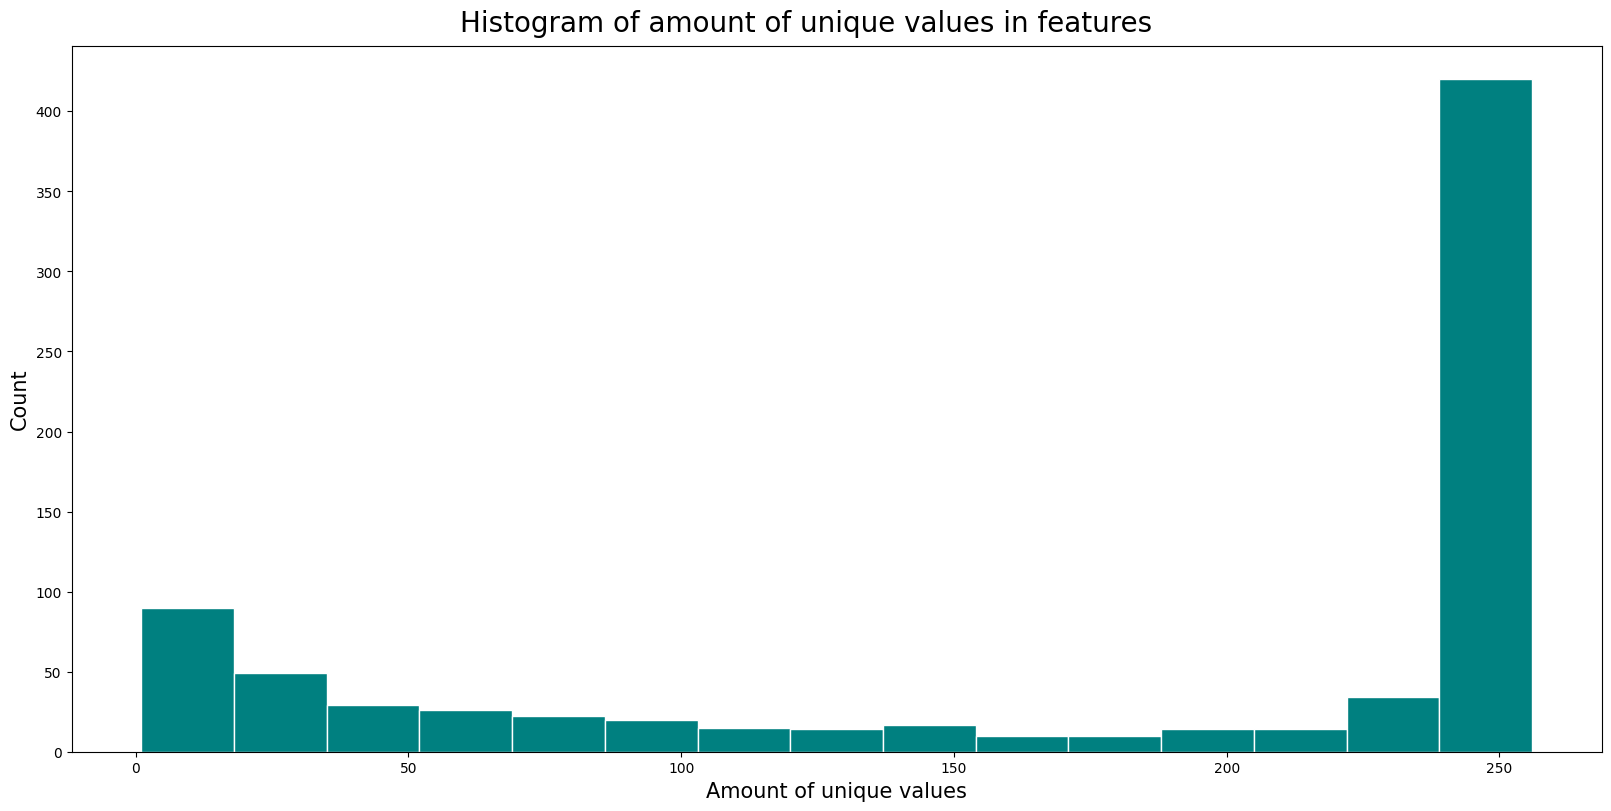

In [7]:
plt.figure(figsize = (16,8), constrained_layout=True)
plt.suptitle("Histogram of amount of unique values in features", fontsize=20)
plt.hist(features.nunique(), bins=15, edgecolor="white", color="teal")
plt.xlabel("Amount of unique values", fontsize=15)
_ = plt.ylabel("Count", fontsize=15)

As we can see from the graph, the vast majority of pixels take on all or `almost all possible values` depending on the image. However, there are also those that do not have a large number of unique values. Let's look at them.

In [8]:
print(f"Columns with a low amount of unique values:\n{features.columns[features.nunique()<10]}")

Columns with a low amount of unique values:
Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel25', 'pixel26', 'pixel27',
       'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel54', 'pixel55',
       'pixel56', 'pixel57', 'pixel58', 'pixel83', 'pixel84', 'pixel85',
       'pixel86', 'pixel112', 'pixel113', 'pixel140', 'pixel141', 'pixel168',
       'pixel196', 'pixel449', 'pixel477', 'pixel504', 'pixel505', 'pixel532',
       'pixel533', 'pixel560', 'pixel561', 'pixel588', 'pixel589', 'pixel616',
       'pixel617', 'pixel644', 'pixel645', 'pixel672', 'pixel673', 'pixel700',
       'pixel701', 'pixel728', 'pixel729', 'pixel730', 'pixel756', 'pixel757',
       'pixel758', 'pixel759', 'pixel783', 'pixel784'],
      dtype='object')


In [9]:
print(f"Columns with only one unique value:\n{features.columns[features.nunique()==1]}")

Columns with only one unique value:
Index(['pixel28'], dtype='object')


In [10]:
print(f"The only value, that 28-th pixel has on our data - {features['pixel28'].unique()[0]}")

The only value, that 28-th pixel has on our data - 0


In [11]:
print(f"Columns with all possible values:\n{features.columns[features.nunique()==256]}")

Columns with all possible values:
Index(['pixel38', 'pixel48', 'pixel76', 'pixel94', 'pixel131', 'pixel132',
       'pixel187', 'pixel234', 'pixel267', 'pixel272', 'pixel290', 'pixel294',
       'pixel300', 'pixel317', 'pixel328', 'pixel346', 'pixel350', 'pixel351',
       'pixel356', 'pixel384', 'pixel412', 'pixel434', 'pixel436', 'pixel457',
       'pixel492', 'pixel496', 'pixel514', 'pixel546', 'pixel574', 'pixel604',
       'pixel658'],
      dtype='object')


Now let's take a look at the histogram of variances (or more precisely, `standard deviations`).

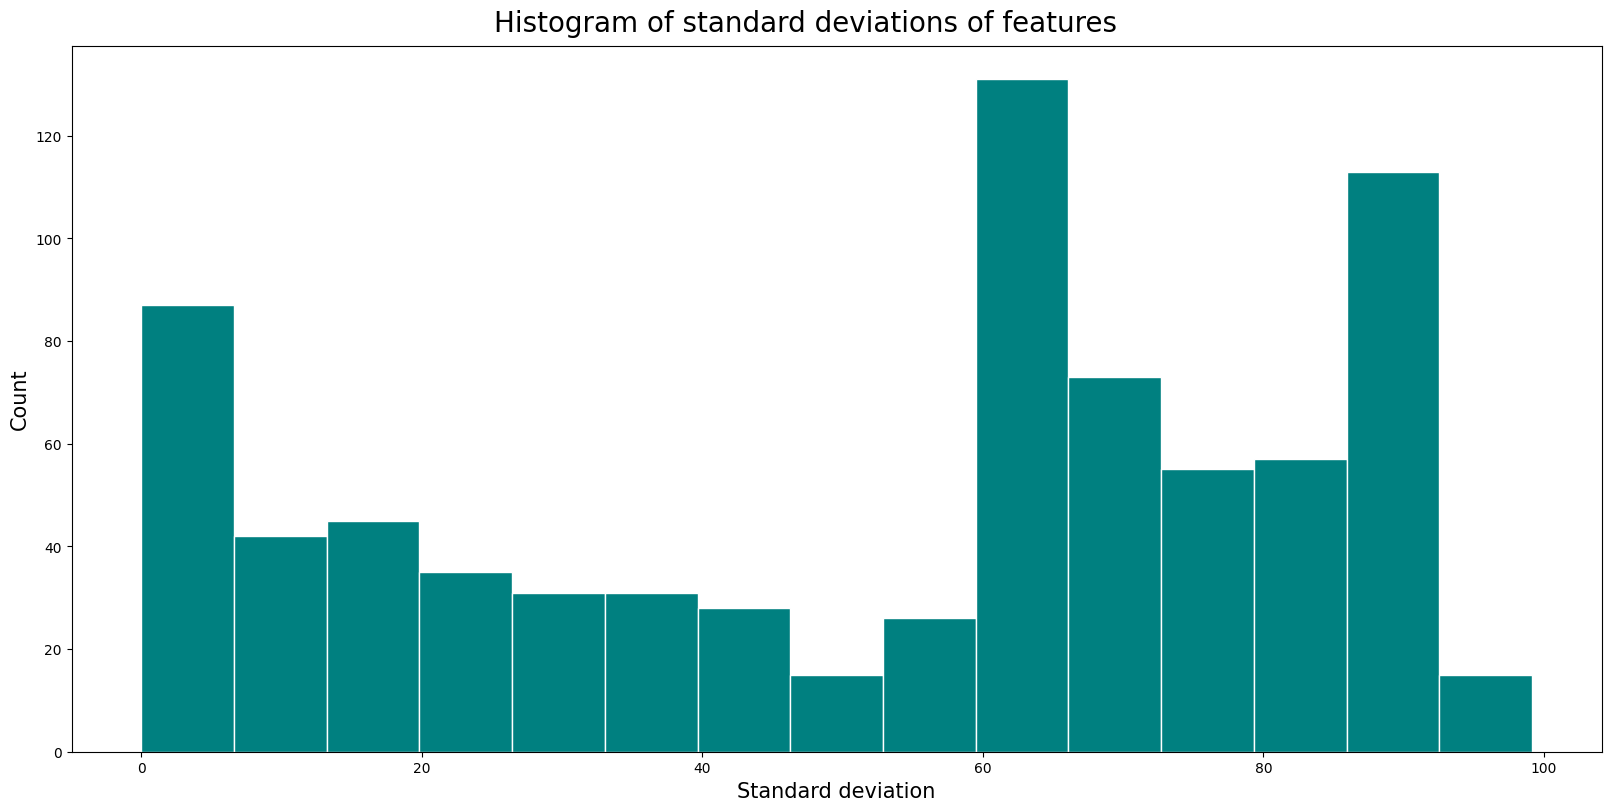

In [12]:
plt.figure(figsize = (16,8), constrained_layout=True)
plt.suptitle("Histogram of standard deviations of features", fontsize=20)
plt.hist(features.std(), bins=15, edgecolor="white", color="teal")
plt.xlabel("Standard deviation", fontsize=15)
_ = plt.ylabel("Count", fontsize=15)

This histogram differs slightly from the previous one, but overall carries similar information. The first bar is relatively high compared to the others, indicating a sufficient number of bars with low variance. Further, the distribution of standard deviations is relatively uniform, and the number of pixels with such values is quite small. At the end, as the standard deviation increases, the number of pixels with such values sharply increases (somewhere after 60) and remains consistently high up to a value of 90, indicating a `large number of bars with high variance`.

In [13]:
print(f"Columns with a low standard deviation:\n{features.columns[features.std()<5]}")

Columns with a low standard deviation:
Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel24',
       'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30',
       'pixel31', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58',
       'pixel59', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86',
       'pixel111', 'pixel112', 'pixel113', 'pixel114', 'pixel140', 'pixel141',
       'pixel168', 'pixel169', 'pixel196', 'pixel224', 'pixel281', 'pixel309',
       'pixel337', 'pixel365', 'pixel392', 'pixel393', 'pixel420', 'pixel421',
       'pixel449', 'pixel476', 'pixel477', 'pixel504', 'pixel505', 'pixel532',
       'pixel533', 'pixel560', 'pixel561', 'pixel588', 'pixel617', 'pixel644',
       'pixel645', 'pixel672', 'pixel700', 'pixel701', 'pixel728', 'pixel729',
       'pixel730', 'pixel755', 'pixel756', 'pixel757', 'pixel758', 'pixel759',
       'pixel760', 'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object')


We can also observe that columns with a small number of unique values almost always have a lower standard deviation compared to other columns.

In [14]:
variances = data.var().sort_values(ascending=False)
print(f"10 features with the highest variance:\n{variances.head(10)}\n")
print(f"10 features with the lowest variance:\n{variances.tail(10)}")

10 features with the highest variance:
pixel743    9830.418038
pixel737    9389.699372
pixel260    9346.793287
pixel738    9314.278738
pixel742    9166.842747
pixel748    9136.061896
pixel274    9021.305152
pixel232    9014.804810
pixel259    8882.089502
pixel246    8840.612588
dtype: float64

10 features with the lowest variance:
pixel112    0.122822
pixel84     0.122482
pixel729    0.102034
pixel758    0.095310
pixel757    0.082490
pixel784    0.082490
pixel2      0.002909
pixel27     0.001667
pixel1      0.000417
pixel28     0.000000
dtype: float64


Summarizing this analysis, we can conclude that although we have a significant number of columns with low variance (which theoretically we can remove from the dataset without significantly affecting the accuracy of our future model), the `vast majority still have high variance`, which means we cannot simply remove them from the dataset. This in turn tells us that we cannot solve the `curse of dimensionality` in this way, which leads us to consider using a different approach, such as `PCA` or `LLE`.

Now let's play around with `correlations` a bit.

In [15]:
corr_matrix = features.corr()
corr_matrix

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
pixel1,1.000000,-0.001104,-0.001977,-0.001069,-0.001888,0.002198,0.000640,-0.004034,-0.006639,-0.011952,...,0.011199,0.013561,0.006988,-0.002556,-0.004231,-0.000649,-0.001606,0.005470,0.021147,-0.000474
pixel2,-0.001104,1.000000,0.005986,0.064310,0.278575,0.038353,-0.006908,0.010474,0.031496,0.040038,...,0.029435,0.044498,0.059036,0.059527,0.036413,-0.003189,0.002870,0.007259,0.006197,-0.001256
pixel3,-0.001977,0.005986,1.000000,0.876368,0.414416,0.071222,0.037892,0.023022,0.011379,0.002943,...,0.029930,0.056193,0.064872,0.063494,0.095220,0.050581,0.021544,0.019905,0.017043,-0.000141
pixel4,-0.001069,0.064310,0.876368,1.000000,0.568115,0.024419,0.010425,0.005001,-0.001084,-0.015552,...,-0.007612,0.006132,0.020319,0.038499,0.071551,0.020579,0.047737,0.051590,0.058438,-0.001215
pixel5,-0.001888,0.278575,0.414416,0.568115,1.000000,0.387341,0.112260,0.041085,0.014003,-0.017410,...,-0.013406,0.021914,0.025413,0.061798,0.116414,0.151252,0.144810,0.199709,0.103992,-0.001527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel780,-0.000649,-0.003189,0.050581,0.020579,0.151252,0.465493,0.410994,0.282522,0.243295,0.090985,...,0.065278,0.150796,0.196328,0.265822,0.583252,1.000000,0.606687,0.320600,0.310134,0.024106
pixel781,-0.001606,0.002870,0.021544,0.047737,0.144810,0.262030,0.287029,0.177705,0.105270,0.021696,...,0.045276,0.099396,0.122096,0.217588,0.363042,0.606687,1.000000,0.765058,0.439289,0.065745
pixel782,0.005470,0.007259,0.019905,0.051590,0.199709,0.274606,0.147278,0.099877,0.030150,-0.010157,...,0.009862,0.043390,0.052214,0.098876,0.205027,0.320600,0.765058,1.000000,0.485765,0.088167
pixel783,0.021147,0.006197,0.017043,0.058438,0.103992,0.046749,0.139743,0.026916,0.012668,-0.010274,...,-0.023339,0.022368,0.024059,0.036089,0.112885,0.310134,0.439289,0.485765,1.000000,0.310990


In [16]:
np.fill_diagonal(corr_matrix.values, np.nan) #To avoid working with values on the diagonal, which are always equal to 1
print(f"Five pairs of columns with the highest correlation between them:\n{corr_matrix.stack().nlargest(10)}\n")
print(f"Five pairs of columns with the lowest correlation between them:\n{corr_matrix.stack().nsmallest(10)}")

Five pairs of columns with the highest correlation between them:
pixel56   pixel784    0.994938
pixel784  pixel56     0.994938
pixel56   pixel757    0.994938
pixel757  pixel56     0.994938
pixel56   pixel84     0.991462
pixel84   pixel56     0.991462
pixel589  pixel617    0.991420
pixel617  pixel589    0.991420
pixel530  pixel558    0.990027
pixel558  pixel530    0.990027
dtype: float64

Five pairs of columns with the lowest correlation between them:
pixel14   pixel681   -0.377565
pixel681  pixel14    -0.377565
pixel14   pixel435   -0.376708
pixel435  pixel14    -0.376708
pixel14   pixel463   -0.375148
pixel463  pixel14    -0.375148
pixel14   pixel653   -0.374333
pixel653  pixel14    -0.374333
pixel14   pixel519   -0.374098
pixel519  pixel14    -0.374098
dtype: float64


In [17]:
am_high_corr = (corr_matrix>0.85).values.sum()/2
am_low_corr = (corr_matrix<-0.85).values.sum()/2
print(f"Amount of pairs with correlation higher than 0.85 - {am_high_corr:.0f}")
print(f"Amount of pairs with correlation lower than -0.85 - {am_low_corr:.0f}")

Amount of pairs with correlation higher than 0.85 - 2037
Amount of pairs with correlation lower than -0.85 - 0


We have more than 2000 positively highly correlated pairs, but we don't have any negatively highly correlated pairs, which is interesting. At first, it may seem like 2037 pairs is a lot, but considering that we have more than 300,000 pairs of features in this dataset overall, it's `not such a large number`, which is certainly a `good sign` for our future models, as a high percentage of strongly correlated pairs of attributes can lead to overfitting in SVM or violation of the assumption that conditional distributions are independent of each other.

Let's look at the correlations between the `target variable` and `features`.

In [18]:
corr_label = data.corr().loc["label",:].drop("label").drop("pixel28") # pixel28 has only one unique value, so his correlation with target variable is impossible
corr_label.describe()

count    783.000000
mean      -0.173798
std        0.320343
min       -0.796286
25%       -0.435186
50%       -0.104252
75%       -0.007597
max        0.493190
Name: label, dtype: float64

In [19]:
print(f"10 features with the highest correlation with the target variable:\n{corr_label.nlargest(10)}\n")
print(f"10 features with the lowest correlation with the target variable:\n{corr_label.nsmallest(10)}")

10 features with the highest correlation with the target variable:
pixel240    0.493190
pixel14     0.478846
pixel268    0.474707
pixel212    0.469073
pixel15     0.460238
pixel296    0.438779
pixel16     0.429214
pixel183    0.421773
pixel184    0.413228
pixel13     0.400975
Name: label, dtype: float64

10 features with the lowest correlation with the target variable:
pixel631   -0.796286
pixel603   -0.787474
pixel575   -0.783796
pixel659   -0.783756
pixel547   -0.781871
pixel681   -0.777857
pixel687   -0.774491
pixel653   -0.770604
pixel519   -0.769343
pixel709   -0.768194
Name: label, dtype: float64


In [20]:
am_zero_corr = corr_label[(corr_label>-0.3) & (corr_label<0.3)].count()
print(f"Amount of features, that are weakly correlated with target variable - {am_zero_corr:.0f}")

Amount of features, that are weakly correlated with target variable - 479


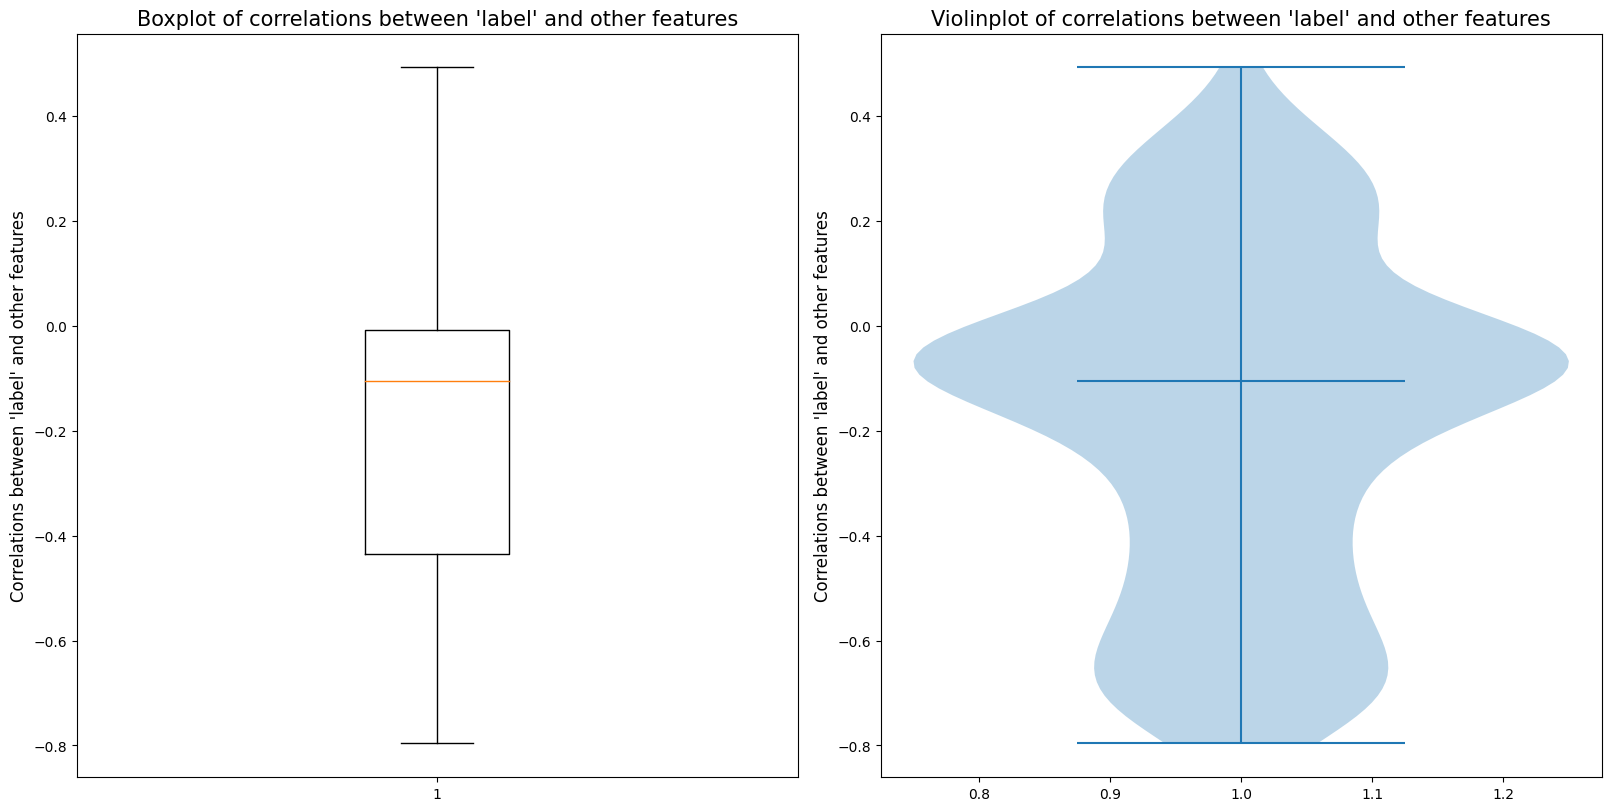

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), constrained_layout=True)

ax1.set_title("Boxplot of correlations between 'label' and other features", fontsize=15)
ax1.set_ylabel("Correlations between 'label' and other features", fontsize=12)
ax1.boxplot(corr_label, widths=0.2)

ax2.set_title("Violinplot of correlations between 'label' and other features", fontsize=15)
ax2.set_ylabel("Correlations between 'label' and other features", fontsize=12)
_ = ax2.violinplot(corr_label, showmedians=True)

As we can see, most of the features are `weakly correlated with the target variable`, and there are no strongly correlated features, that means that there is `no clear linear relationship` between the features and the target.

### Preparing train, validation and test data

Let's split up data into `train`, `validation` and `test` subsets.

In [22]:
rd_seed = 143

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target_var, test_size=0.2, random_state=rd_seed)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.225, random_state=rd_seed)

print(f"Train features dimensions: {Xtrain.shape}")
print(f"Train target variable dimensions: {ytrain.shape}")
print(f"Validation features dimensions: {Xval.shape}")
print(f"Validation target variable dimensions: {yval.shape}")
print(f"Test features dimensions: {Xtest.shape}")
print(f"Test target variable dimensions: {ytest.shape}")

Train features dimensions: (1488, 784)
Train target variable dimensions: (1488,)
Validation features dimensions: (432, 784)
Validation target variable dimensions: (432,)
Test features dimensions: (480, 784)
Test target variable dimensions: (480,)


Let's also prepare `standardised data`.

In [23]:
scaler = StandardScaler()

Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

In [24]:
sns.set_style("white")

### Let's begin training machine learning models

At first, we will train models (SVM, naive Bayes, and LDA) on the dataset we currently have, with `784 features`. We will evaluate the performance of these models on validation data. Then, using PCA and LLE, we will try to `solve the curse of dimensionality`, after which we will `retrain our models on the processed data` and select the best model among all.

#### Support Vector Machine (SVM)

Let's start with `Support Vector Machine`. We have an `image classification` task, that means, that this task  involves high-dimensional data (`784 features`, as we can see). As the dimensionality of the data increases, the likelihood that the underlying relationship between features and target variable becomes `nonlinear` also increases. Because of fact, that SVM is able to learn `complex decision boundaries` that can separate data of different classes that are not linearly separable, we can claime, that Support Vector Machine is `suitable for our task`.

Due to the logic of SVM, which is a `distance-based algorithm` that works by maximizing the margin between the decision boundary and the closest points from each class, I assume that, it is better to train the model on `standardized data` to avoid overweighting some features and underweighting others.

Considering that SVM has a couple of parameters to experiment with, let's focus on finding the best parameters that `yield the highest results on the validation data`. The first parameter is **C** - the regularization parameter (the strength of the regularization is inversely proportional to C). The second parameter is the **kernel** - the type of function used to transform the input data into a higher-dimensional space in which it is easier to separate the classes. In our case, we will try to build a model using a `Linear kernel`, a `Polynomial kernel`, and a `Radial Basis Function (RBF) kernel`. To find `the best pair of hyperparameters` for the SVM, we will write a function.

In [25]:
def find_best_params_SVM (Xtrain, ytrain, Xval, yval, param_comb):
    val_acc = []
    train_acc = []
    xtick_labels = []

    for params in param_comb:
        clf = SVC(**params)
        clf.fit(Xtrain, ytrain)
        train_acc.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain)))
        val_acc.append(metrics.accuracy_score(yval, clf.predict(Xval)))
        xtick_labels.append(f"{params['C']} + {params['kernel']}")

    fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)

    lct=ticker.FixedLocator(range(0,len(param_comb))) 
    ax.xaxis.set_major_locator(lct)

    fmt=ticker.FixedFormatter(xtick_labels) 
    ax.xaxis.set_major_formatter(fmt)

    ax.plot(train_acc, 'or-', label="train")
    ax.plot(val_acc, 'ob-', label="validation")
    ax.tick_params(axis='x', rotation=90, labelsize=14)
    ax.set_xlabel("hyperparameter combination", fontsize=15)
    ax.set_ylabel("accuracy", fontsize=15)
    ax.set_title("Classification accuracy depending on hyperparameter combination (SVM)", fontsize=18)
    ax.legend(fontsize=14)

    best_params = param_comb[np.argmax(val_acc)]
    print(f"The best pair of hyperparameters has the following values: C - {best_params['C']}, kernel - {best_params['kernel']}.")
    
    return best_params

Let's train the SVM first on original data, and then on standardized data. Using a `validation subset`, we'll assess whether my assumption was correct.

The best pair of hyperparameters has the following values: C - 1.0, kernel - rbf.


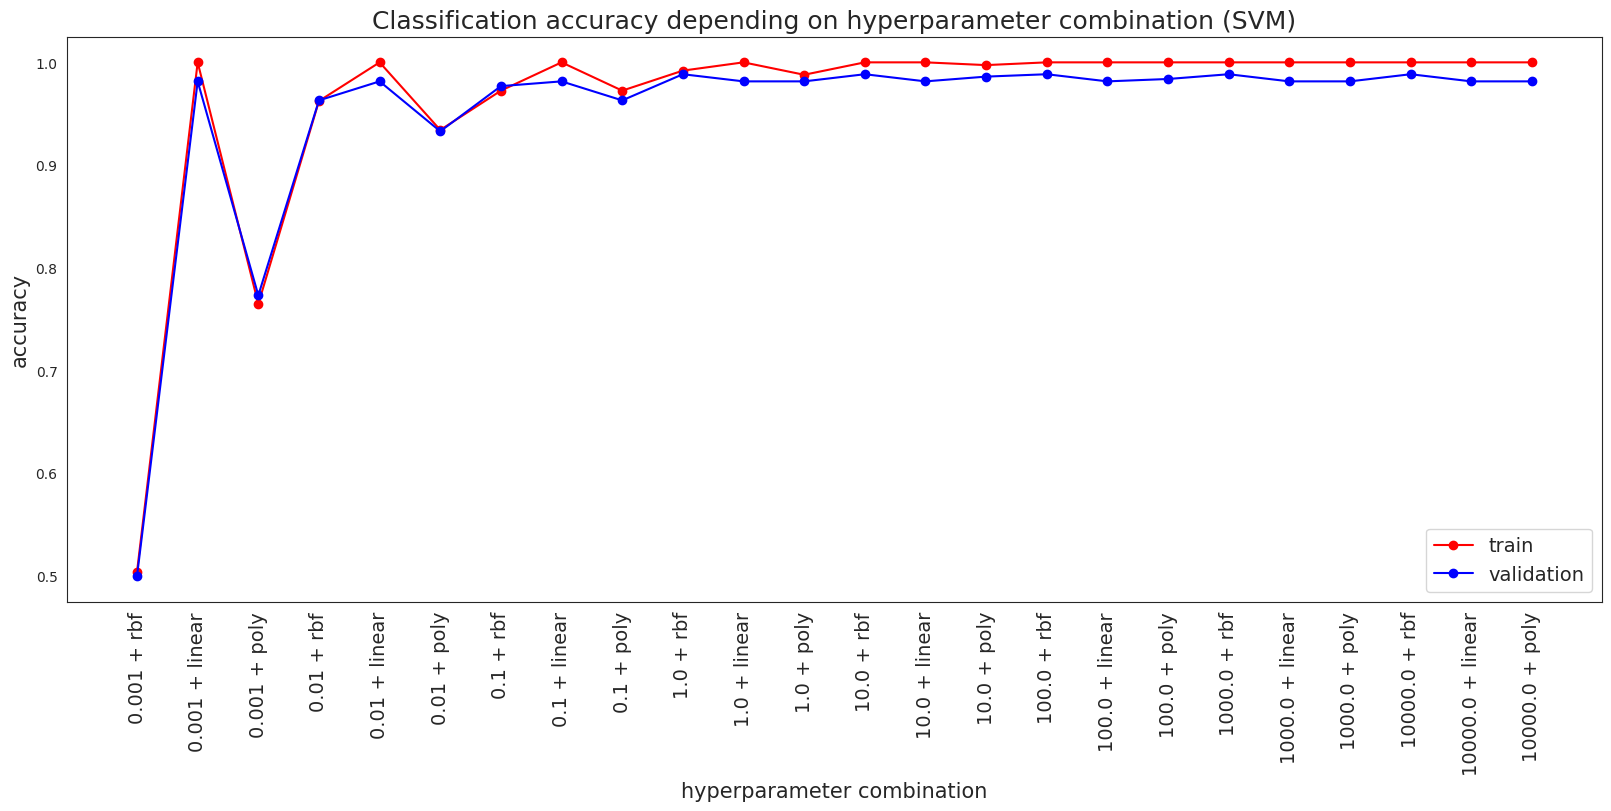

In [26]:
C_values = np.logspace(-3, 4, num=8)

param_grid_svm = { 
    "kernel": ["rbf", "linear", "poly"],
    "C": C_values
}

param_comb_svm = ParameterGrid(param_grid_svm)
best_params = find_best_params_SVM(Xtrain, ytrain, Xval, yval, param_comb_svm)

The best pair of hyperparameters has the following values: C - 10.0, kernel - rbf.


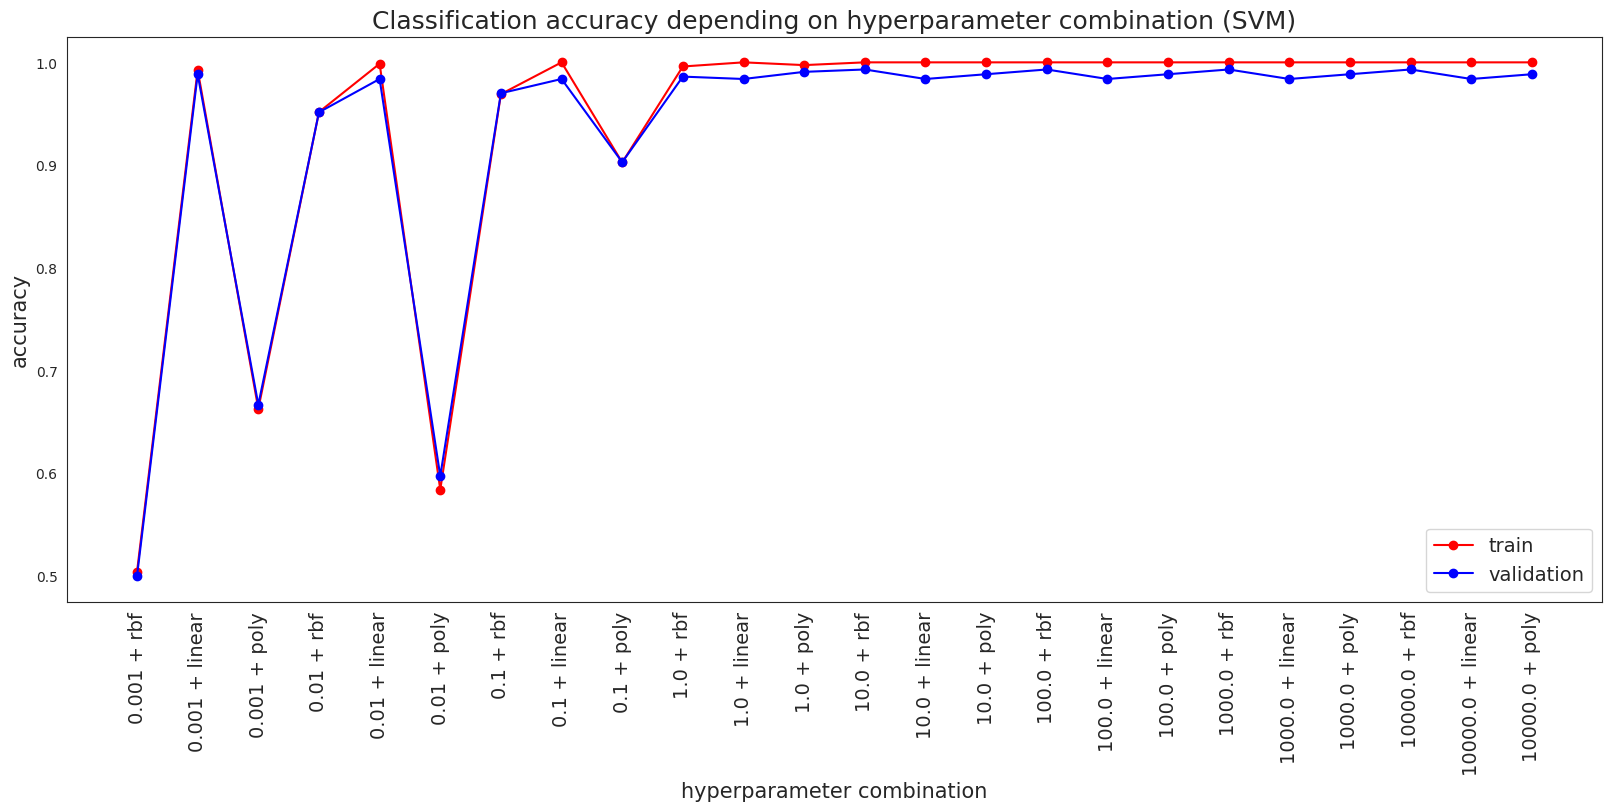

In [27]:
best_params_s = find_best_params_SVM(Xtrain_scaled, ytrain, Xval_scaled, yval, param_comb_svm)

We can see that for small values of the **C** parameter, the `polynomial kernel` performs the worst, while for large values, the `linear kernel` gives the worst results. This is quite logical, since the regularization of the data decreases with increasing **C**, which means that we `pay more attention to the data itself`. As we already mentioned earlier, due to the large number of features in our dataset, the probability that we are dealing with a linear problem is quite small.

In [28]:
svm = SVC(**best_params)
svm.fit(Xtrain, ytrain)
print(f"Accuracy score (train dataset): {metrics.accuracy_score(ytrain,svm.predict(Xtrain)):.3f}")
print(f"Accuracy score (validation dataset): {metrics.accuracy_score(yval,svm.predict(Xval)):.3f}")

Accuracy score (train dataset): 0.992
Accuracy score (validation dataset): 0.988


In [29]:
svm = SVC(**best_params_s)
svm.fit(Xtrain_scaled, ytrain)
print(f"Accuracy score (train dataset): {metrics.accuracy_score(ytrain,svm.predict(Xtrain_scaled)):.3f}")
print(f"Accuracy score (validation dataset): {metrics.accuracy_score(yval,svm.predict(Xval_scaled)):.3f}")

Accuracy score (train dataset): 1.000
Accuracy score (validation dataset): 0.993


As we can see, the difference in accuracy score on validation data between model with the best parameters, that was trained on original data and model with the best parameters, that was trained on standardized data is small enough. However, model on standardized data is a `bit better`.

Let's play around with another hyperparameter - **gamma**. Gamma controls the shape of the decision boundary, a high gamma value can lead to `overfitting`, where the model is `too complex` and has learned the noise in the data, while a low gamma value can lead to `underfitting`, where the model is `too simple` and cannot capture the complex patterns in the data. 

In [30]:
gammas = np.logspace(-7, 0, num=8)
for gamma in gammas:
    svm = SVC(**best_params_s, gamma=gamma)
    svm.fit(Xtrain_scaled, ytrain)
    gamma_format = '{:.{}f}'.format(gamma, 7).rstrip('0').rstrip('.')
    print(f"Accuracy score for gamma equals to {gamma_format} (train dataset): {metrics.accuracy_score(ytrain,svm.predict(Xtrain_scaled)):.3f}")
    print(f"Accuracy score for gamma equals to {gamma_format} (validation dataset): {metrics.accuracy_score(yval,svm.predict(Xval_scaled)):.3f}\n")

Accuracy score for gamma equals to 0.0000001 (train dataset): 0.872
Accuracy score for gamma equals to 0.0000001 (validation dataset): 0.884

Accuracy score for gamma equals to 0.000001 (train dataset): 0.962
Accuracy score for gamma equals to 0.000001 (validation dataset): 0.968

Accuracy score for gamma equals to 0.00001 (train dataset): 0.986
Accuracy score for gamma equals to 0.00001 (validation dataset): 0.975

Accuracy score for gamma equals to 0.0001 (train dataset): 0.995
Accuracy score for gamma equals to 0.0001 (validation dataset): 0.988

Accuracy score for gamma equals to 0.001 (train dataset): 1.000
Accuracy score for gamma equals to 0.001 (validation dataset): 0.993

Accuracy score for gamma equals to 0.01 (train dataset): 1.000
Accuracy score for gamma equals to 0.01 (validation dataset): 0.961

Accuracy score for gamma equals to 0.1 (train dataset): 1.000
Accuracy score for gamma equals to 0.1 (validation dataset): 0.567

Accuracy score for gamma equals to 1 (train data

The best accuracy score remained `unchanged`.

Just out of curiosity, let's see what is the highest accuracy score on the validation data that SVM with a `polynomial kernel` gave us.

In [31]:
svm_poly = SVC(C=10, kernel="poly")
svm_poly.fit(Xtrain_scaled, ytrain)
print(f"Accuracy score (train dataset): {metrics.accuracy_score(ytrain,svm_poly.predict(Xtrain_scaled)):.3f}")
print(f"Accuracy score (validation dataset): {metrics.accuracy_score(yval,svm_poly.predict(Xval_scaled)):.3f}")

Accuracy score (train dataset): 1.000
Accuracy score (validation dataset): 0.988


We will train the model with the best hyperparameters again, as we will need it in the future. We will also save the `highest classification accuracy` that we were able to achieve with SVM.

In [32]:
svm = SVC(**best_params_s)
svm.fit(Xtrain_scaled, ytrain)
Nsupp = svm.support_.shape[0]
print(f"Amount of support vectors {Nsupp}. It is {100*Nsupp/Xtrain_scaled.shape[0]:.1f}% of training data.")

Amount of support vectors 247. It is 16.6% of training data.


In [33]:
svm_best_score = metrics.accuracy_score(yval,svm.predict(Xval_scaled))

#### Naive Bayes

Let's continue with `Naive Bayes`. First of all, this model is really suitable for this task, because of the fact, that `Naive Bayes doesn't suffer from the curse of dimensionality`. Another advantage of **Naive Bayes** is its `simplicity and efficiency`, as it can quickly train on large datasets and make predictions with low computational cost. We will see that **Naive Bayes** trains models much faster than **SVM** and **LDA**. Naive Bayes assumes that the features are `conditionally independent given the class label`, which may be a reasonable assumption for our task since during the statistical measurements we have seen that the number of highly correlated features isn't big enough.

First, we will train `Gaussian Naive Bayes`, which will treat our features as `continuous data`. This model has no parameters for setting up, so we will simply train it on our original and standardized data and evaluate the performance of these models.

In [34]:
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
print(f"Accuracy score (train dataset): {metrics.accuracy_score(ytrain,gnb.predict(Xtrain)):.3f}")
print(f"Accuracy score (validation dataset): {metrics.accuracy_score(yval,gnb.predict(Xval)):.3f}")

Accuracy score (train dataset): 0.890
Accuracy score (validation dataset): 0.898


In [35]:
print(f"Classes: {gnb.classes_}")
print(f"Amount of samples for every class: {gnb.class_count_}")
print(f"Probability estimates for each class: {gnb.class_prior_}")

Classes: [0 1]
Amount of samples for every class: [750. 738.]
Probability estimates for each class: [0.50403226 0.49596774]


In [36]:
gnb_s = GaussianNB()
gnb_s.fit(Xtrain_scaled, ytrain)
print(f"Accuracy score (train dataset): {metrics.accuracy_score(ytrain,gnb_s.predict(Xtrain_scaled)):.3f}")
print(f"Accuracy score (validation dataset): {metrics.accuracy_score(yval,gnb_s.predict(Xval_scaled)):.3f}")

Accuracy score (train dataset): 0.870
Accuracy score (validation dataset): 0.887


As we can see, this model performs `significantly worse` in terms of classification accuracy on the validation set (regardless of whether the data was standardized or not) compared to SVM.

Now let's consider our features as `discrete` and train a `Multinomial Naive Bayes` model. In this case, we have one parameter - `alpha`, that is used in additive smoothing.

In [37]:
mnb = MultinomialNB(alpha=1, force_alpha=False)
mnb.fit(Xtrain, ytrain)
print(f"Accuracy score for alpha = 1 (train dataset): {metrics.accuracy_score(ytrain,mnb.predict(Xtrain)):.3f}")
print(f"Accuracy score for alpha = 1 (validation dataset): {metrics.accuracy_score(yval,mnb.predict(Xval)):.3f}\n")

alphas = range(10,101,10)
for alpha in alphas:
    mnb = MultinomialNB(alpha=alpha, force_alpha=False)
    mnb.fit(Xtrain, ytrain)
    print(f"Accuracy score for alpha = {alpha} (train dataset): {metrics.accuracy_score(ytrain,mnb.predict(Xtrain)):.3f}")
    print(f"Accuracy score for alpha = {alpha} (validation dataset): {metrics.accuracy_score(yval,mnb.predict(Xval)):.3f}\n")

Accuracy score for alpha = 1 (train dataset): 0.952
Accuracy score for alpha = 1 (validation dataset): 0.956

Accuracy score for alpha = 10 (train dataset): 0.952
Accuracy score for alpha = 10 (validation dataset): 0.956

Accuracy score for alpha = 20 (train dataset): 0.952
Accuracy score for alpha = 20 (validation dataset): 0.956

Accuracy score for alpha = 30 (train dataset): 0.952
Accuracy score for alpha = 30 (validation dataset): 0.956

Accuracy score for alpha = 40 (train dataset): 0.952
Accuracy score for alpha = 40 (validation dataset): 0.956

Accuracy score for alpha = 50 (train dataset): 0.952
Accuracy score for alpha = 50 (validation dataset): 0.956

Accuracy score for alpha = 60 (train dataset): 0.952
Accuracy score for alpha = 60 (validation dataset): 0.956

Accuracy score for alpha = 70 (train dataset): 0.952
Accuracy score for alpha = 70 (validation dataset): 0.956

Accuracy score for alpha = 80 (train dataset): 0.952
Accuracy score for alpha = 80 (validation dataset): 0

This model is already better than the previous one and doesn't lag behind SVM as much. What is interesting, that the perfomance of the model doesn't depend on value of parameter `alpha`. It may mean, that the distribution of the features in the training dataset may be relatively `smooth and continuous`, so adding smoothing may not have a significant impact on the classification performance of the model.

It is important to note that we did not train the MultinomialNB model on standardized data because then we would not be able to treat them as discrete variables.

Also save the `highest classification accuracy` that we were able to achieve with Gaussian Naive Bayes, cause we will need it in the future.

In [38]:
gnb_score = metrics.accuracy_score(yval,gnb.predict(Xval))

#### Linear Discriminant Analysis (LDA)

Now let's train `Linear Discriminant Analysis` model. **LDA** is particularly useful when dealing with high-dimensional datasets (that we have in our task) because it can effectively reduce the dimensionality of the dataset while preserving the discriminatory power between the classes. In high-dimensional datasets, there can be a lot of `noise or redundant information` in the data. LDA overcomes this issue by finding a projection of the data that `maximizes the separation between the classes`, which can significantly improve the classification performance. Moreover **LDA** is often used as an option, that can reduce the dimensionality of the dataset and solve `the curse of dimensionality`, so we can train models after that.

**LDA** has one hyperparameter to set up - `solver`, which specifies the algorithm to use for `solving the optimization problem` in **LDA**. We will build a model with every solver (`svd`, `lsqr` and `eigen`). Using the validation subset, we will evaluate which of the solvers is the best.

Starting with original data.

In [39]:
solvers = ["svd", "lsqr", "eigen"]

for solver in solvers:
    if solver == "svd":
        shrinkage = None
    else:
        shrinkage = "auto"
    lda = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)
    lda.fit(Xtrain, ytrain)
    print(f"Accuracy score for {solver} solver (train dataset): {metrics.accuracy_score(ytrain,lda.predict(Xtrain)):.3f}")
    print(f"Accuracy score for {solver} solver (validation dataset): {metrics.accuracy_score(yval,lda.predict(Xval)):.3f}\n")

Accuracy score for svd solver (train dataset): 1.000
Accuracy score for svd solver (validation dataset): 0.914

Accuracy score for lsqr solver (train dataset): 0.993
Accuracy score for lsqr solver (validation dataset): 0.977

Accuracy score for eigen solver (train dataset): 0.993
Accuracy score for eigen solver (validation dataset): 0.977



The solvers `lsqr` and `eigen` performed better than `svd` and are equally good. The overall classification accuracy of the **LDA** is better than that of the Naive Bayes, but it `still slightly lags behind SVM`.

Now let's train on standardized data.

In [40]:
for solver in solvers:
    if solver == "svd":
        shrinkage = None
    else:
        shrinkage = "auto"
    lda = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)
    lda.fit(Xtrain_scaled, ytrain)
    print(f"Accuracy score for {solver} solver (train dataset): {metrics.accuracy_score(ytrain,lda.predict(Xtrain_scaled)):.3f}")
    print(f"Accuracy score for {solver} solver (validation dataset): {metrics.accuracy_score(yval,lda.predict(Xval_scaled)):.3f}\n")

Accuracy score for svd solver (train dataset): 1.000
Accuracy score for svd solver (validation dataset): 0.914

Accuracy score for lsqr solver (train dataset): 0.993
Accuracy score for lsqr solver (validation dataset): 0.979

Accuracy score for eigen solver (train dataset): 0.993
Accuracy score for eigen solver (validation dataset): 0.979



As we can see, the results are almost the `same regardless` of whether the data was raw or standardized before training.

Saving the model with solver `eigen` and the value of the highest accuracy on the validation data.

In [41]:
lda = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto")
lda.fit(Xtrain_scaled, ytrain)
lda_best_score = metrics.accuracy_score(yval,lda.predict(Xval_scaled))

### Reduction of dimensionality

Let's tackle the `curse of dimensionality` and try to reduce the number of features. To do this, we will use statistical techniques such as `PCA` and `LLE`. With the help of the machine learning models we used before, we will try to find the `best dimensionality` for our data and train the best model.

#### Principal Component Analysis (PCA)

At the beginning we don't know, what number of components we want to keep to `obtain a model with better accuracy`, or at least not much worse, while significantly `reducing the dimensionality of the dataset`, in order to `avoid overfitting` the model in the future. 

Let's try to guess the dimension using the Maximum Likelihood Estimation (MLE) criterion to determine the number of principal components to retain.

In [42]:
pca_mle = PCA(n_components="mle", svd_solver="full")
PCA_MLEtrain = pca_mle.fit_transform(Xtrain)

In [43]:
print(f"The number of principal components to retain after using Maximum Likelihood Estimation - {pca_mle.n_components_}")

The number of principal components to retain after using Maximum Likelihood Estimation - 749


As we can see, the dimensionality after using MLE didn't decrease much, which means the `curse of dimensionality is not solved`. Well, let's try to find a suitable dimensionality ourselves.

In **PCA** there is one interesting parameter to experiment: `n_components`. As we mentioned earlier, we don't know the number of components we want to keep, so we will leave this parameter at its `default` value (equal to the number of features).

Performing **PCA** on the training data and applies the transformation to the validation data.

In [44]:
pca = PCA()
PCAtrain = pca.fit_transform(Xtrain)
PCAval = pca.transform(Xval)

Let's take a look at the percentage of how each of the first 50 principal components `covers the variance` of the entire data and draw plots, that show, how `MSE between original data and reduced data` and `proportion of the total variance` changes with the number of components.

In [45]:
for i in range(50):
    print(f"Variance explained by the {i+1} principal component is {pca.explained_variance_[i]:.2f},\nProportion of the total: {pca.explained_variance_ratio_[i]:.2f},\tCumulative proportion of the total: {pca.explained_variance_ratio_[0:i+1].sum():.2f}")

Variance explained by the 1 principal component is 1057174.10,
Proportion of the total: 0.37,	Cumulative proportion of the total: 0.37
Variance explained by the 2 principal component is 458496.74,
Proportion of the total: 0.16,	Cumulative proportion of the total: 0.53
Variance explained by the 3 principal component is 138559.52,
Proportion of the total: 0.05,	Cumulative proportion of the total: 0.58
Variance explained by the 4 principal component is 106927.89,
Proportion of the total: 0.04,	Cumulative proportion of the total: 0.62
Variance explained by the 5 principal component is 95858.82,
Proportion of the total: 0.03,	Cumulative proportion of the total: 0.65
Variance explained by the 6 principal component is 75721.92,
Proportion of the total: 0.03,	Cumulative proportion of the total: 0.68
Variance explained by the 7 principal component is 65774.95,
Proportion of the total: 0.02,	Cumulative proportion of the total: 0.70
Variance explained by the 8 principal component is 44061.38,
Pro

In [46]:
MSEs = np.zeros(pca.n_components_//16)
VARs = np.zeros(pca.n_components_//16)

for i in range(0, pca.n_components_, 16):
    _pca = PCA(n_components = i+1)
    _PCAtrain = _pca.fit_transform(Xtrain)
    MSEs[i//16] = metrics.mean_squared_error(Xtrain, _pca.inverse_transform(_PCAtrain))
    VARs[i//16] = np.sum(_pca.explained_variance_ratio_)

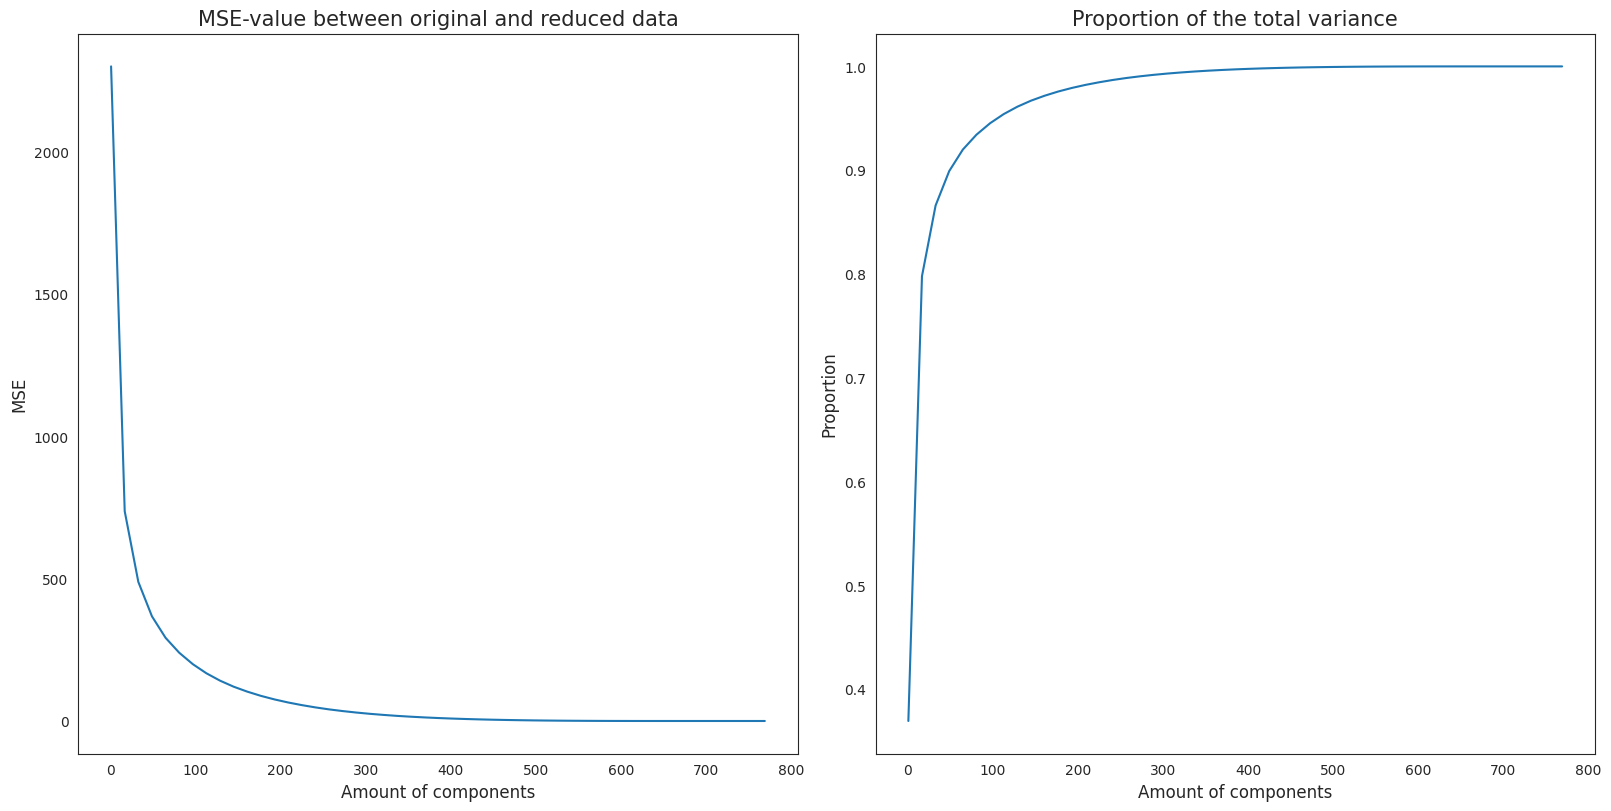

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), constrained_layout=True)

ax1.set_title("MSE-value between original and reduced data", fontsize=15)
ax1.set_ylabel("MSE", fontsize=12)
ax1.set_xlabel("Amount of components", fontsize=12)
ax1.plot(np.array(range(0, pca.n_components_, 16)) + 1, MSEs)

ax2.set_title("Proportion of the total variance", fontsize=15)
ax2.set_ylabel("Proportion", fontsize=12)
ax2.set_xlabel("Amount of components", fontsize=12)
_ = ax2.plot(np.array(range(0, pca.n_components_, 16)) + 1, VARs)

In [48]:
cumulative_prop = np.array([])
i = 0
while i < pca.n_components_:
    cumulative_prop = np.append(cumulative_prop, pca.explained_variance_ratio_[0:i+1].sum())
    i += 1
print(f"Amount of principal components, that cover 99% of original data - {np.searchsorted(cumulative_prop, 0.99)}.")

Amount of principal components, that cover 99% of original data - 267.


The summary of what we saw above:
* Around 50 principal components are sufficient to cover 90% of the total variance of the data.
* After this value a cumulative proportion of the total variance increases very slow and mse decreases very slow.
* First principal covers 37% of the total variance, that is really `high percent` for one component. It means, that even one-dimensional dataset will give us an accuracy, that will not be significantly lower.

Now let's create two functions that will be very helpful in avoiding rewriting the same code multiple times. First function will train models (**SVM**, **Naive Bayes** and **LDA**) for different `amount of features` (that we will pass to the function). Second function will draw accuracies on training and validation data for each dimension and compare it with the highest accuracy, that we have on `784 features`.

In [49]:
def train_after_PCA(PCAtrain, PCAval, ytrain, yval, clf, components):
    train_acc = np.array([])
    val_acc = np.array([])

    for amount in components:
        ntrain = PCAtrain[:,0:amount]
        nval = PCAval[:,0:amount]
        clf.fit(ntrain, ytrain) 
        train_acc = np.append(train_acc, metrics.accuracy_score(ytrain, clf.predict(ntrain)))
        val_acc = np.append(val_acc, metrics.accuracy_score(yval, clf.predict(nval)))
    return train_acc, val_acc

In [50]:
def draw_scores_after_PCA (train_acc, val_acc, best_score, components, title, ylabel):
    fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)
    ax.scatter(components, train_acc, s = 100, c="red", label="train")
    ax.scatter(components, val_acc, s = 100, c="blue", label="validation")
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Number of components in PCA", fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.plot([min(components), max(components)], [best_score, best_score],'g-', lw=3)
    ax.legend(fontsize=14)

Let's start by training SVM on different numbers of features. To keep the training and dimensionality search relatively short, we will always at first take the number of features with a `margin of 16`.

The best accuracy score = 0.99306, amount of components - 33.


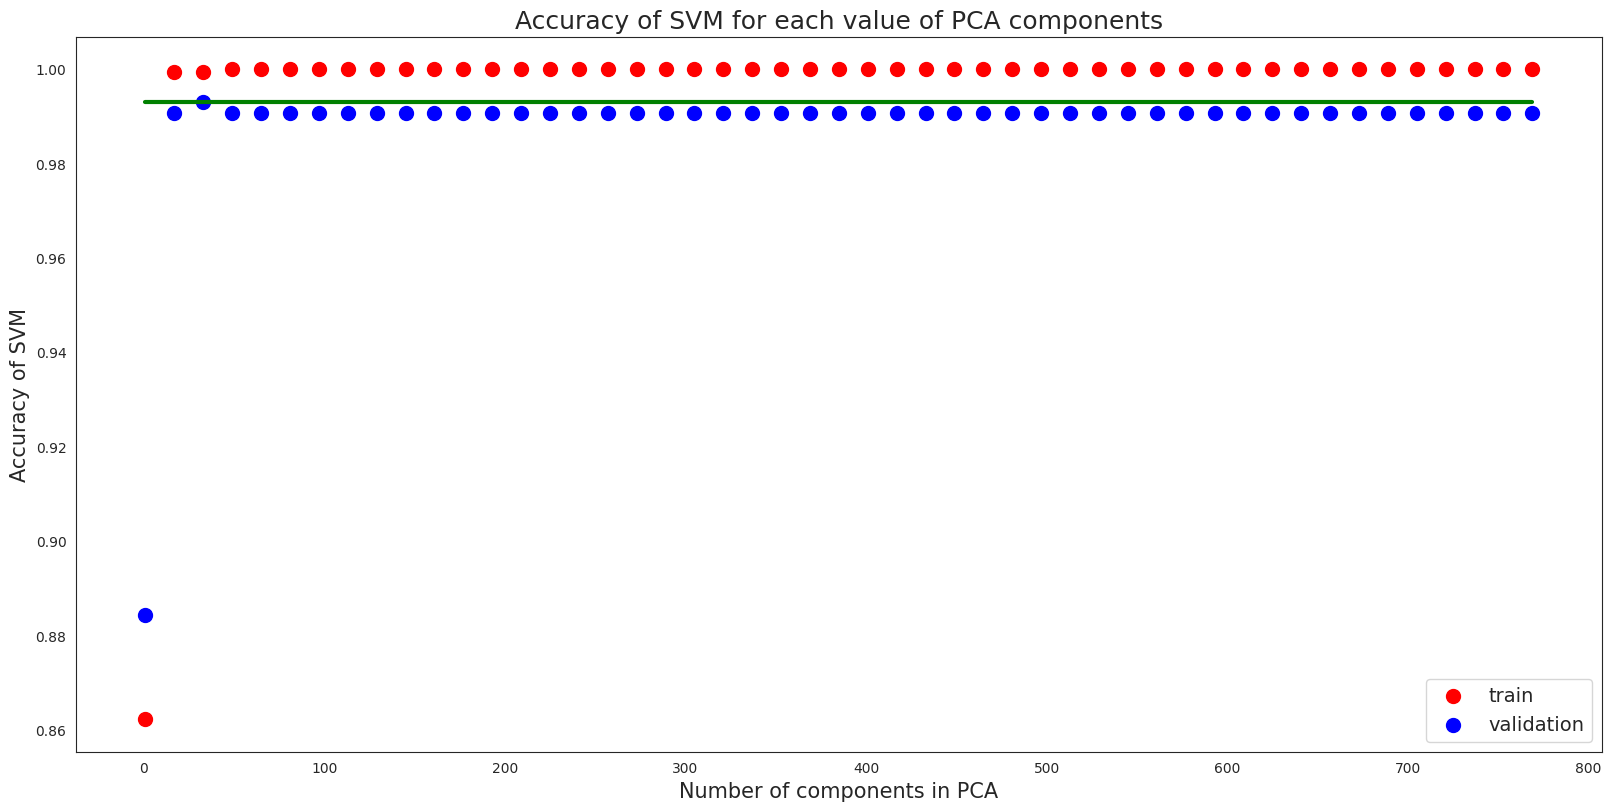

In [51]:
train_acc, val_acc = train_after_PCA(PCAtrain, PCAval, ytrain, yval, svm, range(1,pca.n_components_,16))
draw_scores_after_PCA (train_acc, val_acc, svm_best_score, range(1,pca.n_components_,16), "Accuracy of SVM for each value of PCA components", "Accuracy of SVM")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The graph shows that starting from approximately 15 features, the accuracy of the models on the validation data does not decrease, and starting from 40 features, it does not change at all. This indicates that we can `significantly reduce the number of features` without being afraid of losing the accuracy of the model.

We should also note that, as we mentioned earlier, even with only one feature, the accuracy of the model will `remain quite good`. This, in turn, allows us to see what our data looks like if it consists of only one or two principal components.

In [52]:
twodim_train = PCAtrain[:,0:2]
twodim_val = PCAval[:,0:2]
svm.fit(twodim_train, ytrain)
print(f"SVM accuracy on validation data with only two features - {metrics.accuracy_score(yval, svm.predict(twodim_val)):.2f}")

SVM accuracy on validation data with only two features - 0.9629629629629629


To do this, we will write the following function, which will plot the data as a projection onto a `two-dimensional space`.

In [53]:
def draw_two_dim_graph (twodim_train, ytrain, method):
    cmap_bold = ListedColormap(['#0000ff', '#ff0000'])
    fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)
    scatter = ax.scatter(twodim_train[:, 0], twodim_train[:, 1], c=ytrain, cmap=cmap_bold, alpha=0.5)
    ax.set_title(f"Two-dimensional train subset (Two principal components {method})", fontsize=18)
    ax.set_xlabel("First principal component", fontsize=15)
    ax.set_ylabel("Second principal component", fontsize=15)
    _ = plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")

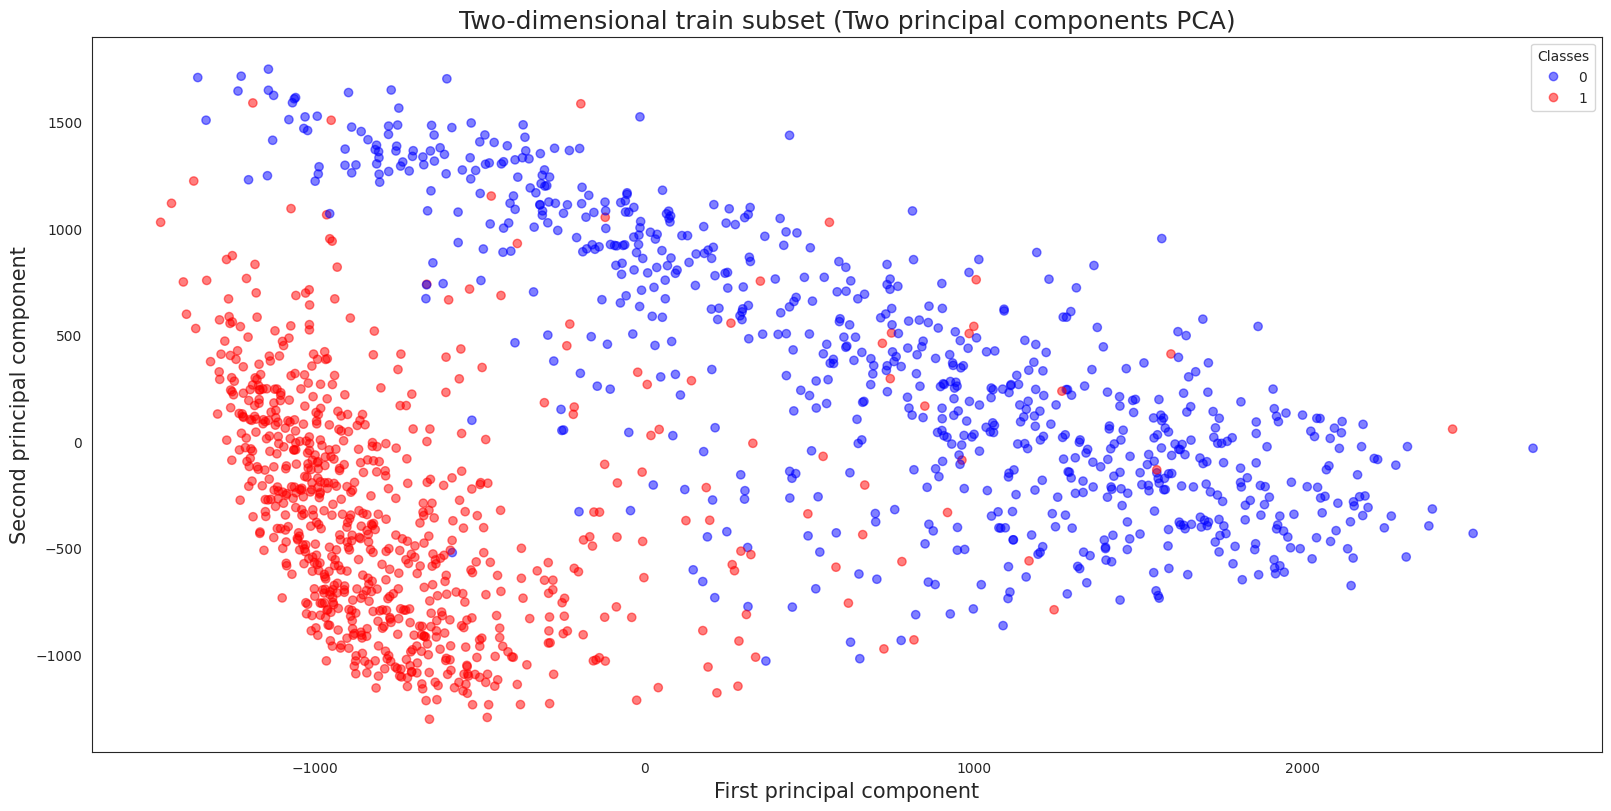

In [54]:
draw_two_dim_graph(twodim_train, ytrain, "PCA")

It is not surprising that the accuracy remains high even for a two-dimensional dataset, as the projection using PCA onto a two-dimensional dataset `preserves the boundary` between the two classes quite well (with the exception of a few red points). The left bottom corner looks especially good, where a large number of points are located and all of them are of the red color, indicating that we were able to `preserve the properties` of this class quite well.

Now let's try to find the `number of features` at which the model has the `highest accuracy` (if there are several such numbers, we will choose the smallest), exploring the vicinity of the best result so far - 33.

The best accuracy score = 0.99537, amount of components - 21.


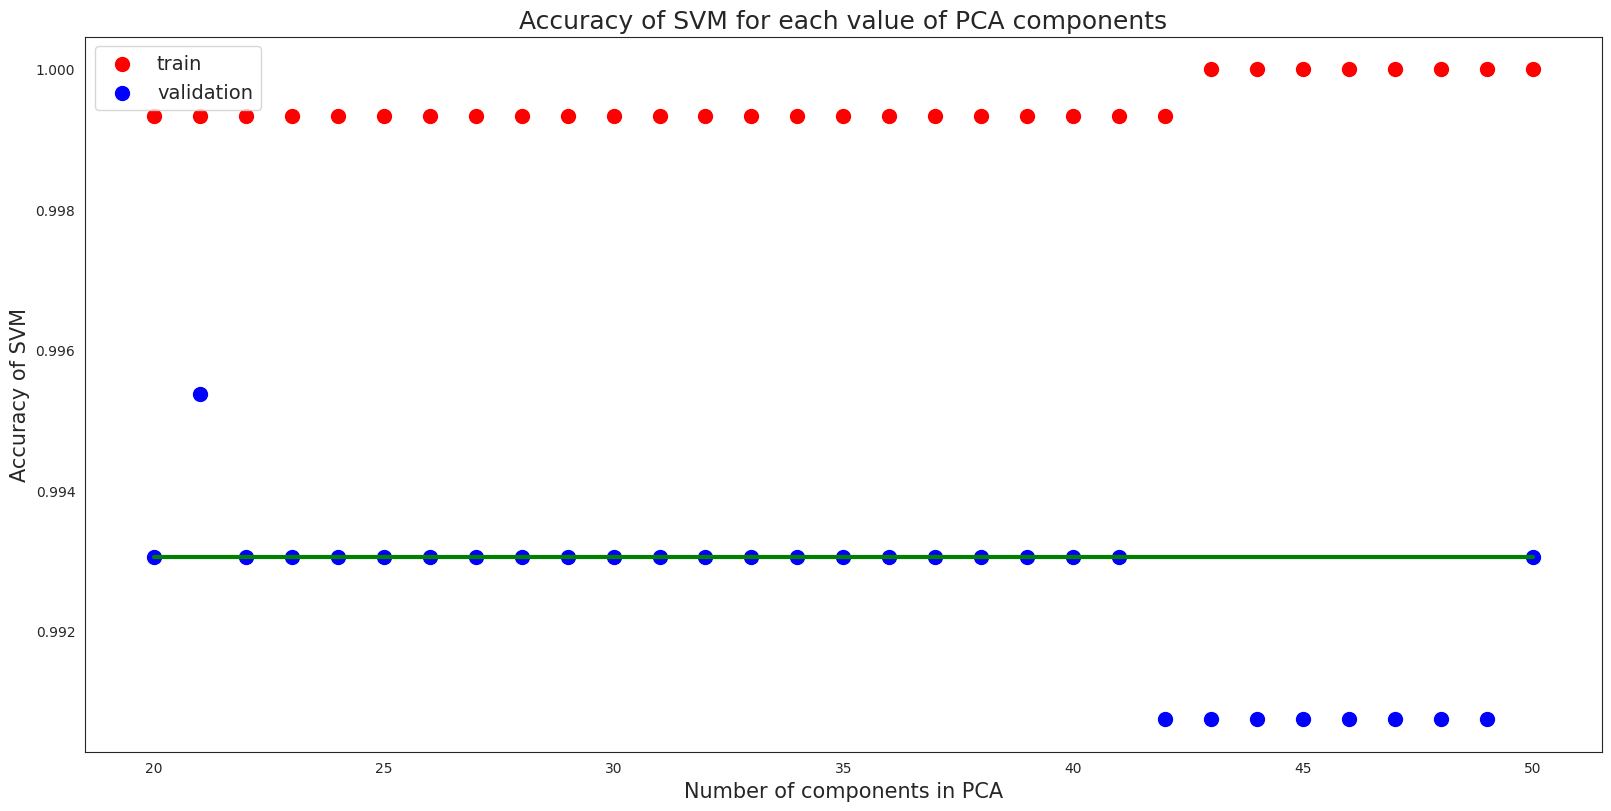

In [55]:
train_acc, val_acc = train_after_PCA(PCAtrain, PCAval, ytrain, yval, svm, range(20,51))
draw_scores_after_PCA (train_acc, val_acc, svm_best_score, range(20,51), "Accuracy of SVM for each value of PCA components", "Accuracy of SVM")
print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) + 20}.")

We will continue to use the same logic in search of the best accuracy. First, we will find an `approximate range` where this performance should be, and then we will `explore this range`.

Now let's move on to **Naive Bayes**. The procedure will be the same as before.

The best accuracy score = 0.98380, amount of components - 33.


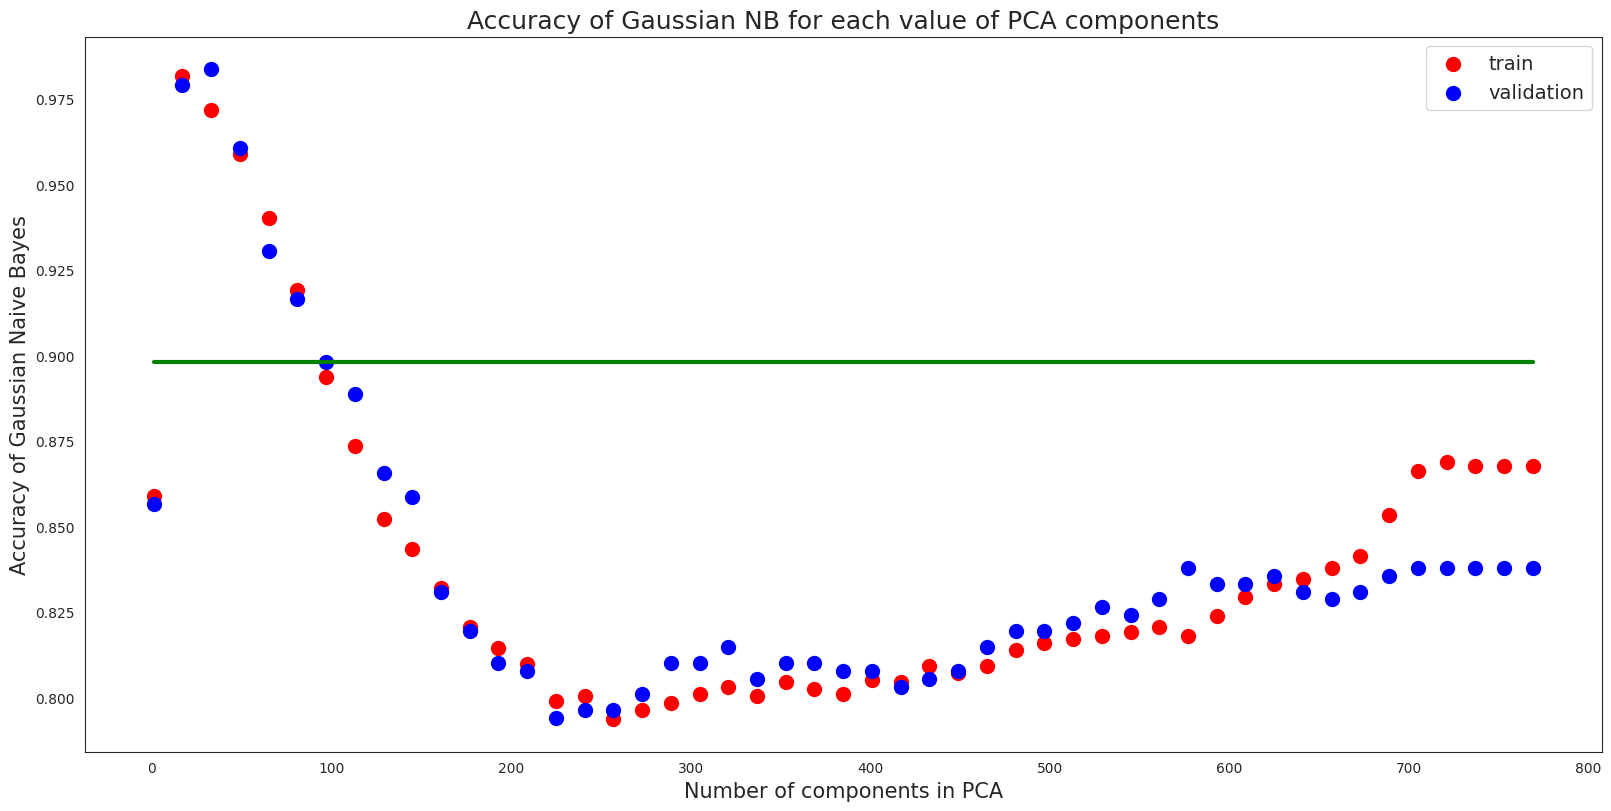

In [56]:
train_acc, val_acc = train_after_PCA(PCAtrain, PCAval, ytrain, yval, gnb, range(1,pca.n_components_,16))
draw_scores_after_PCA (train_acc, val_acc, gnb_score, range(1,pca.n_components_,16), "Accuracy of Gaussian NB for each value of PCA components", "Accuracy of Gaussian Naive Bayes")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The best accuracy score = 0.98380, amount of components - 32.


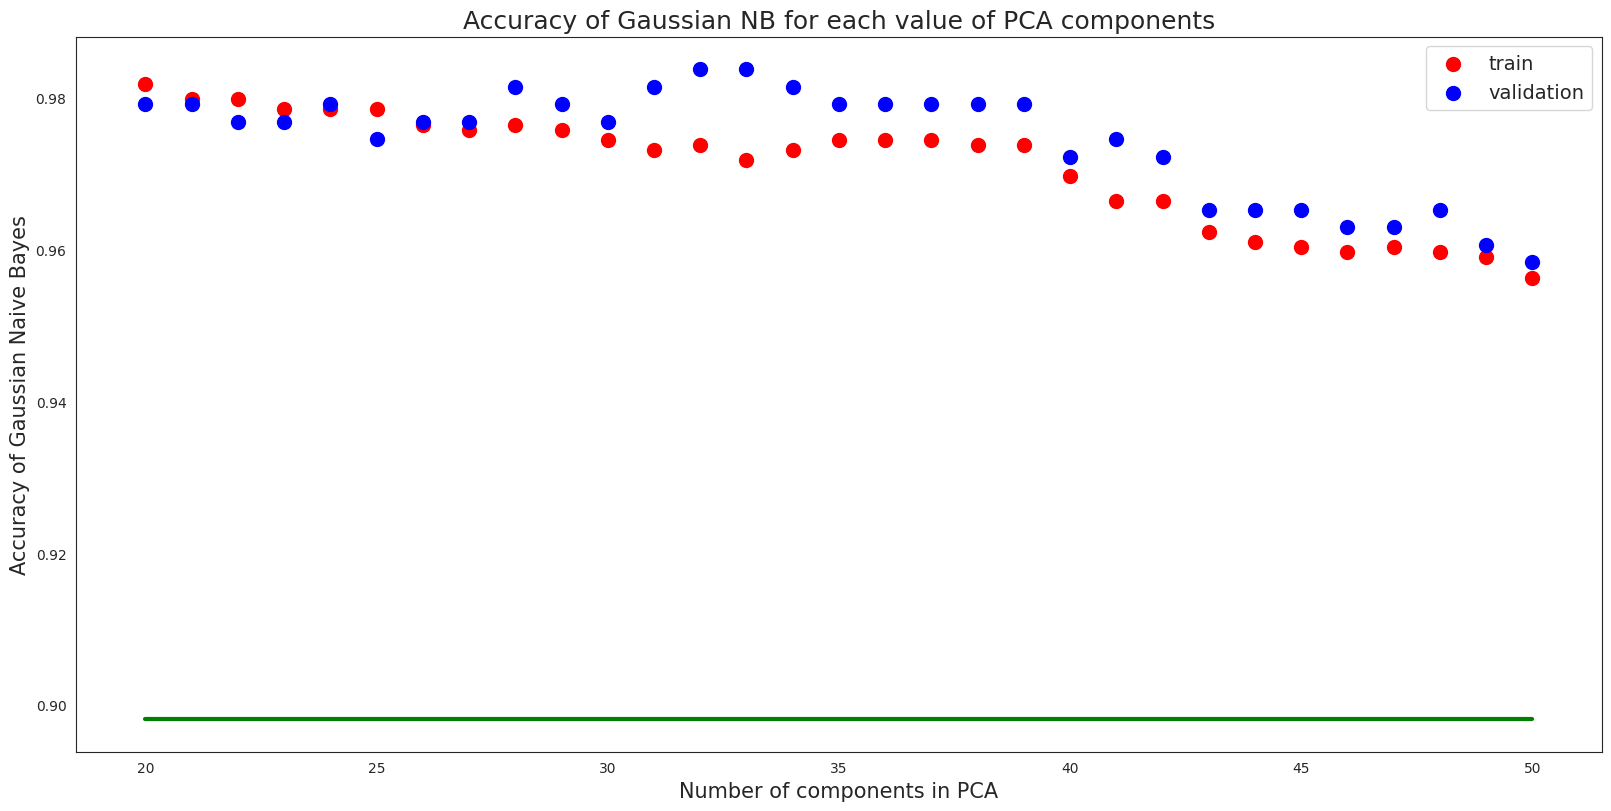

In [57]:
train_acc, val_acc = train_after_PCA(PCAtrain, PCAval, ytrain, yval, gnb, range(20,51))
draw_scores_after_PCA (train_acc, val_acc, gnb_score, range(20,51), "Accuracy of Gaussian NB for each value of PCA components", "Accuracy of Gaussian Naive Bayes")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) + 20}.")

As we can see, despite the fact that Naive Bayes is `quite robust to the curse of dimensionality`, we managed to significantly improve (by 10 percent) the accuracy of our model by reducing the number of features. It is interesting that starting from around 40 features, the accuracy of the model `rapidly decreases`, after which the models give a much worse result. And only after 200 features, the accuracy slowly begins to rise again. This may indicate that in reality, our data are `not conditionally independent given the target variable`, but when the dimensionality is reduced, they become independent, which gives a `sharp jump in the accuracy` of the model.

Continue with **LDA**.

The best accuracy score = 0.98843, amount of components - 113.


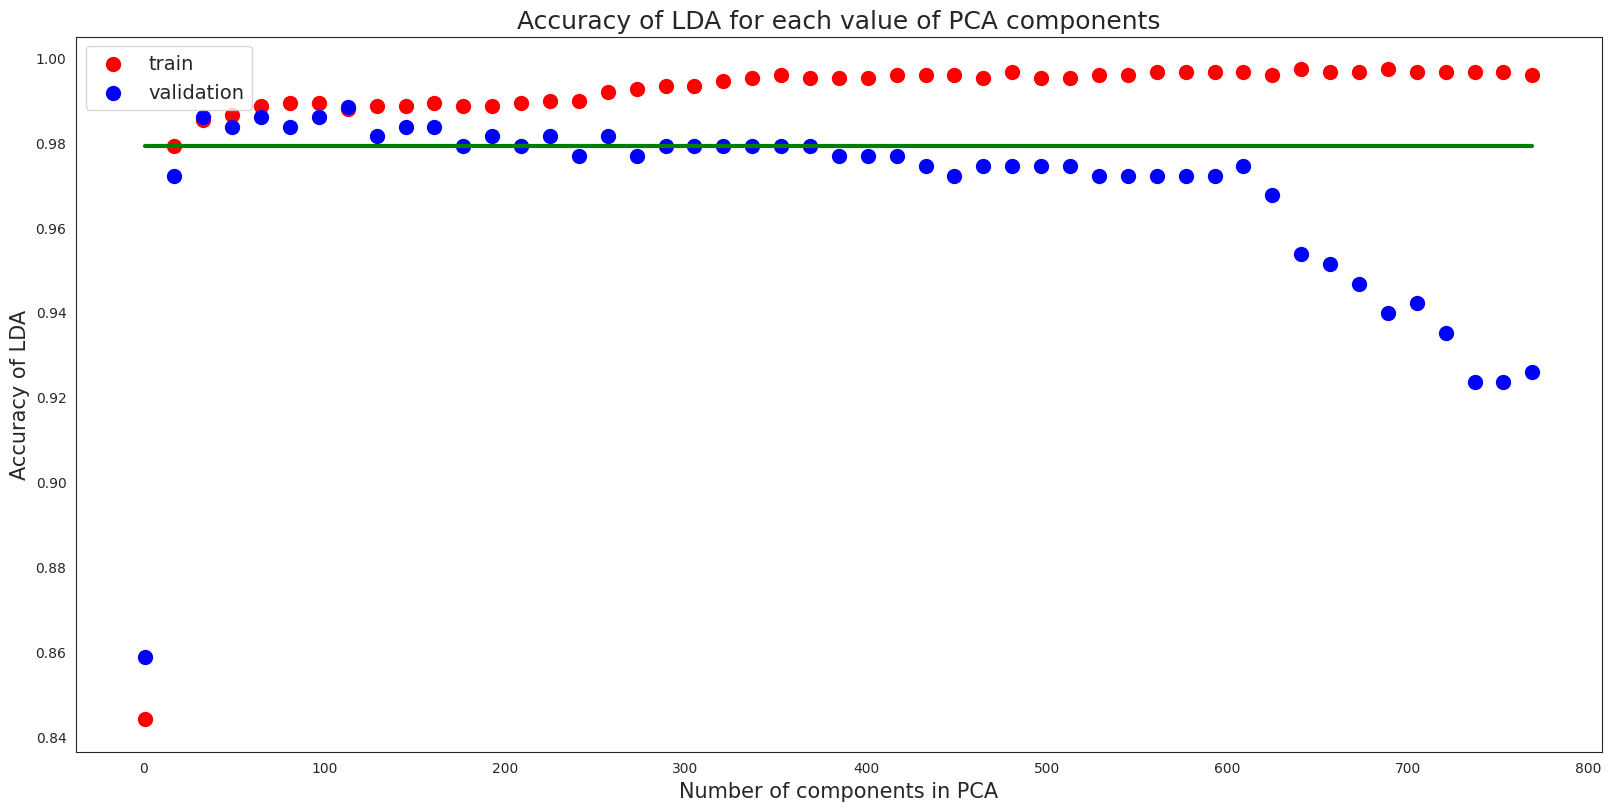

In [58]:
train_acc, val_acc = train_after_PCA(PCAtrain, PCAval, ytrain, yval, lda, range(1,pca.n_components_,16))
draw_scores_after_PCA (train_acc, val_acc, lda_best_score, range(1,pca.n_components_,16), "Accuracy of LDA for each value of PCA components", "Accuracy of LDA")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The best accuracy score = 0.99074, amount of components - 95.


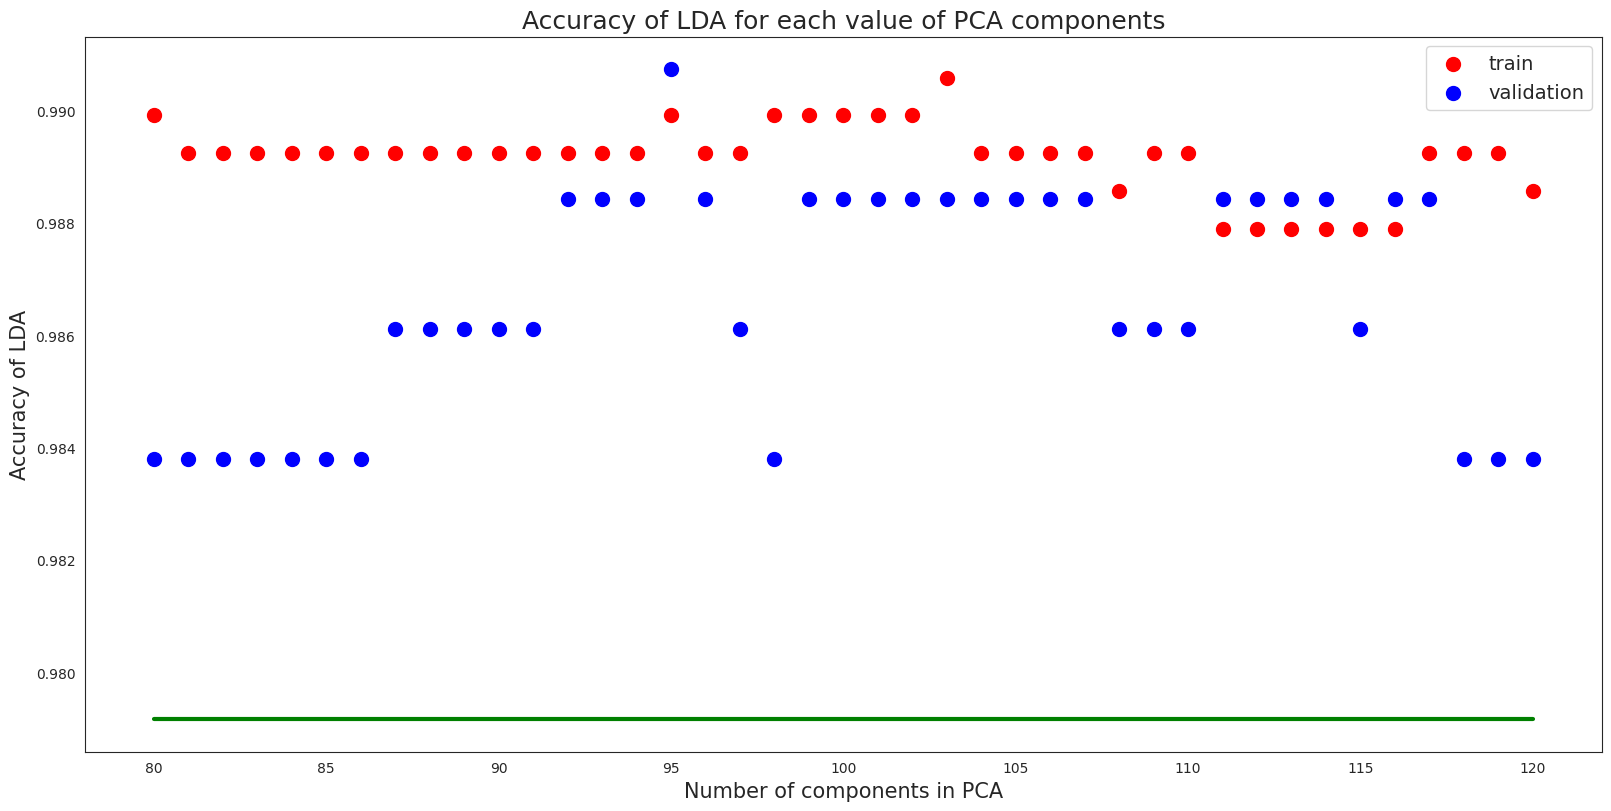

In [59]:
train_acc, val_acc = train_after_PCA(PCAtrain, PCAval, ytrain, yval, lda, range(80,121))
draw_scores_after_PCA (train_acc, val_acc, lda_best_score, range(80,121), "Accuracy of LDA for each value of PCA components", "Accuracy of LDA")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) + 80}.")

As we can see, reducing dimensionality using PCA also `improved the accuracy of the LDA model`. Unlike the two previous models, the number of features that give the best accuracy here is `several times higher`. Overall, the accuracy is approximately the same starting from 40 features and ending around 600, after which it starts to decrease sharply.

Now let's see if the fact that we `run PCA on already standardized data` will have any impact on the accuracy of our models.

In [60]:
PCAtrain_s = pca.fit_transform(Xtrain_scaled)
PCAval_s = pca.transform(Xval_scaled)

The best accuracy score = 0.99537, amount of components - 49.


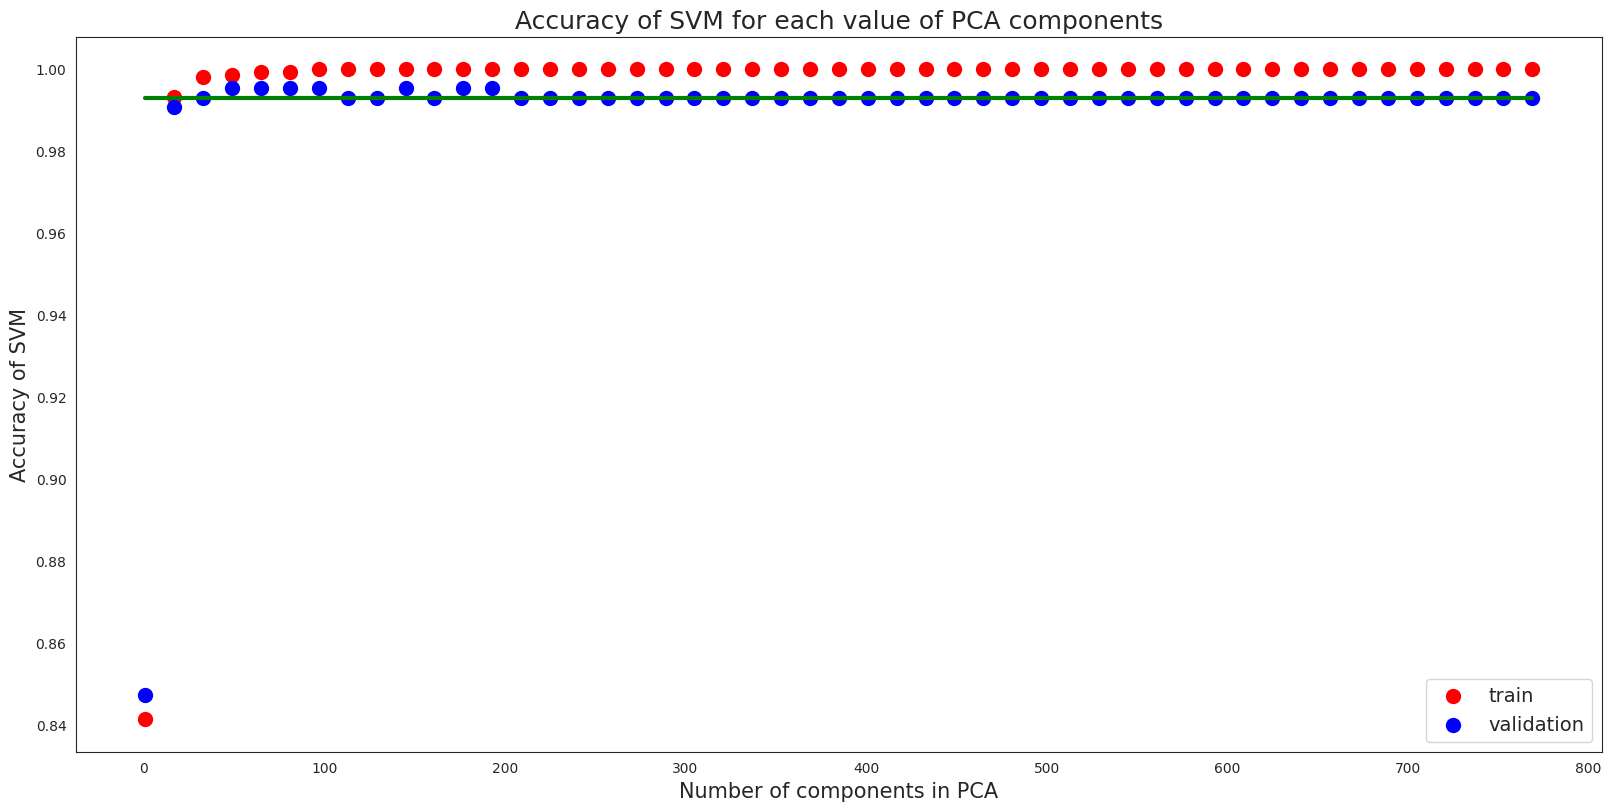

In [61]:
train_acc, val_acc = train_after_PCA(PCAtrain_s, PCAval_s, ytrain, yval, svm, range(1,pca.n_components_,16))
draw_scores_after_PCA (train_acc, val_acc, svm_best_score, range(1,pca.n_components_,16), "Accuracy of SVM for each value of PCA components", "Accuracy of SVM")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The best accuracy score = 0.99537, amount of components - 36.


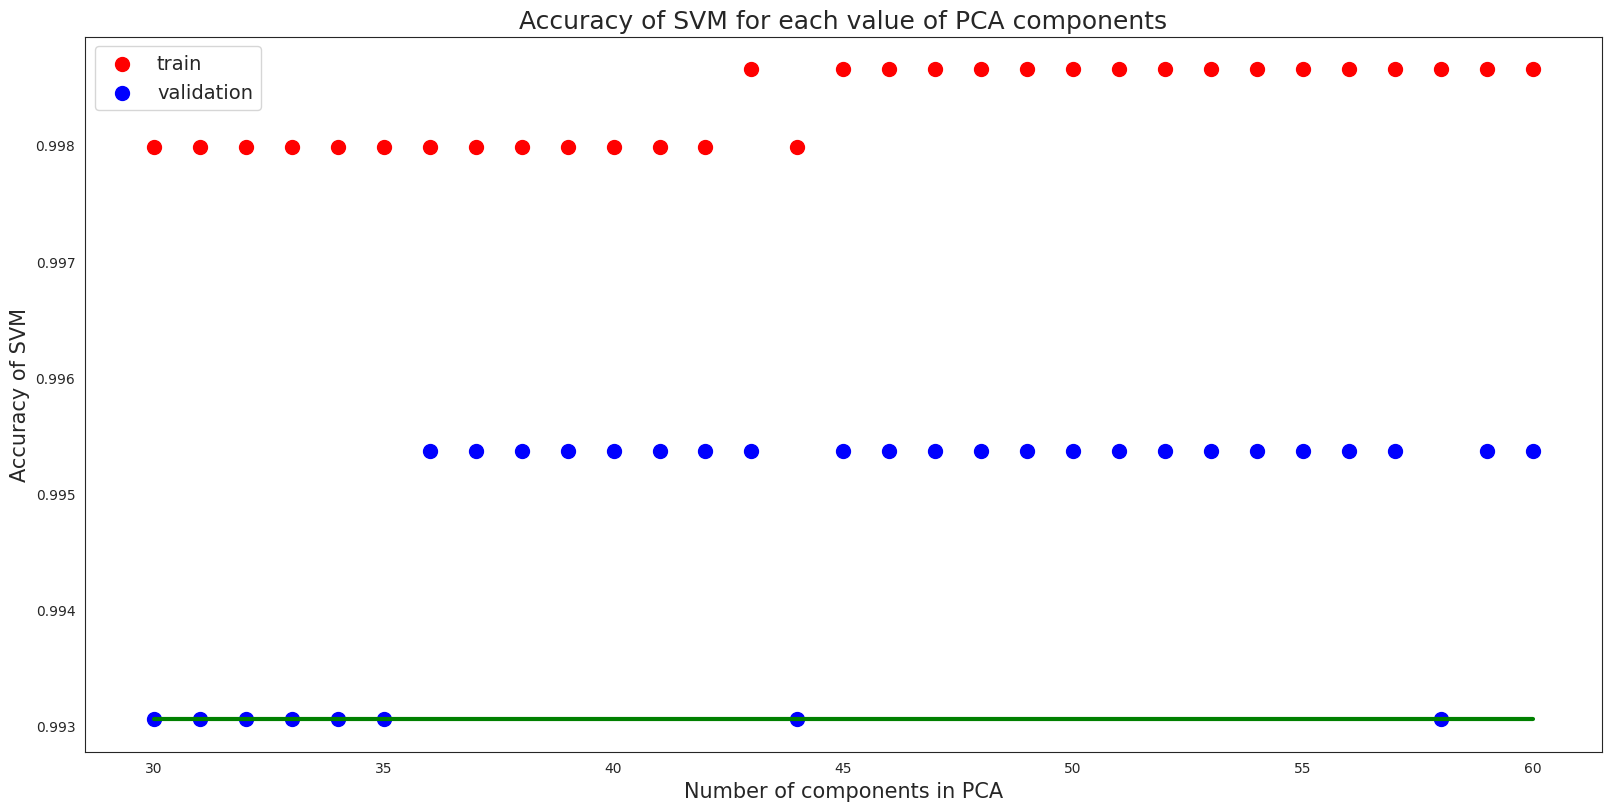

In [62]:
train_acc, val_acc = train_after_PCA(PCAtrain_s, PCAval_s, ytrain, yval, svm, range(30,61))
draw_scores_after_PCA (train_acc, val_acc, svm_best_score, range(30,61), "Accuracy of SVM for each value of PCA components", "Accuracy of SVM")
print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) + 30}.")

For **SVM** situation is almost the same, only the accuracy has `slightly increased`.

The best accuracy score = 0.85648, amount of components - 17.


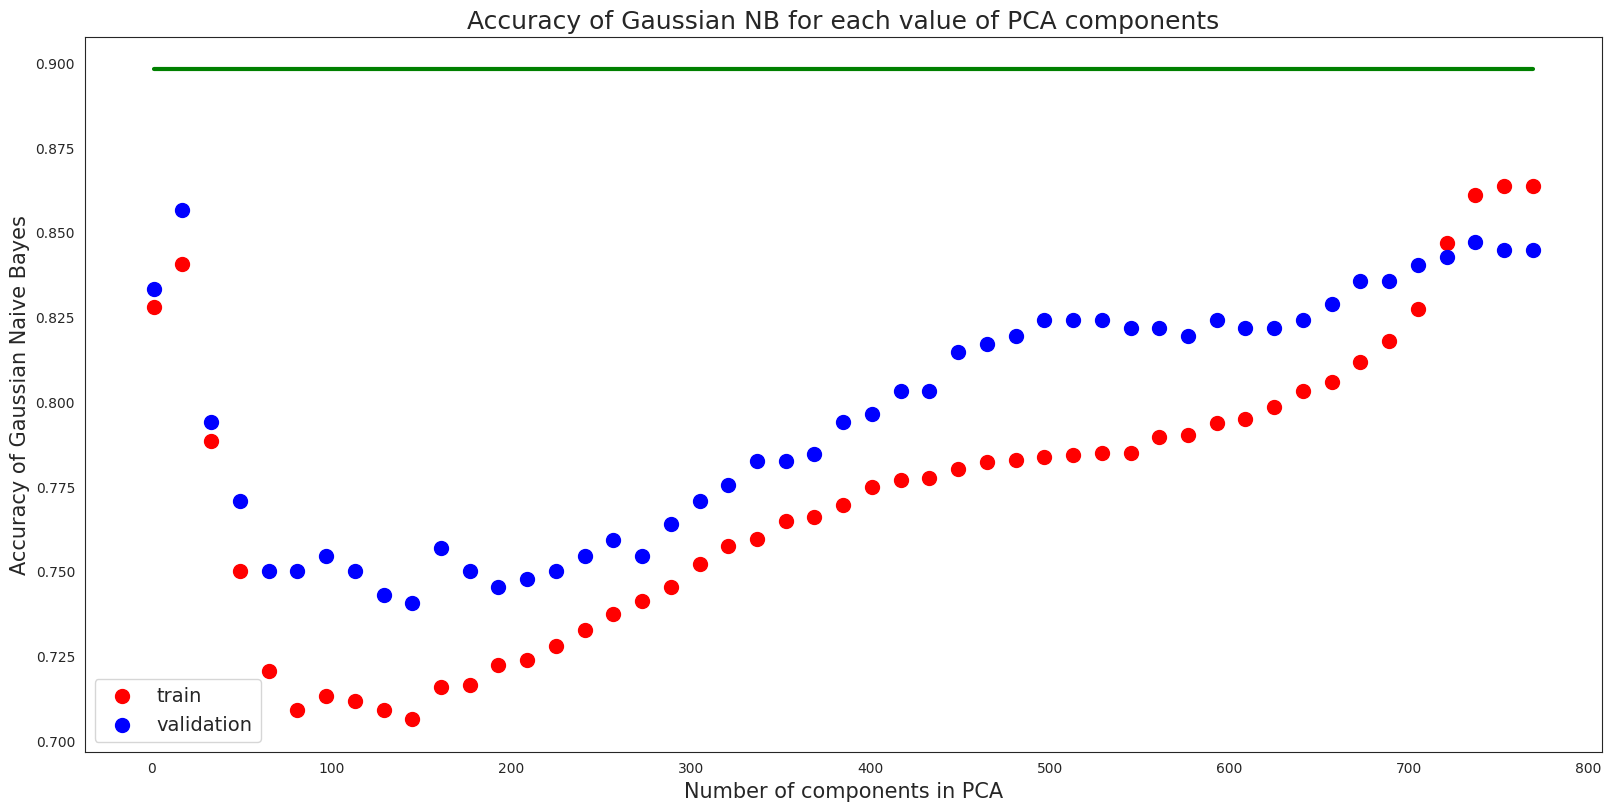

In [63]:
train_acc, val_acc = train_after_PCA(PCAtrain_s, PCAval_s, ytrain, yval, gnb, range(1,pca.n_components_,16))
draw_scores_after_PCA (train_acc, val_acc, gnb_score, range(1,pca.n_components_,16), "Accuracy of Gaussian NB for each value of PCA components", "Accuracy of Gaussian Naive Bayes")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

For the Naive Bayes model, on the contrary, this led to a `significant decrease in model accuracy`. We also saw the same thing with `784 features`. This may indicate that after standardization even after reduction of dimensionality features remain conditionally dependent given the target variable.

The best accuracy score = 0.98380, amount of components - 113.


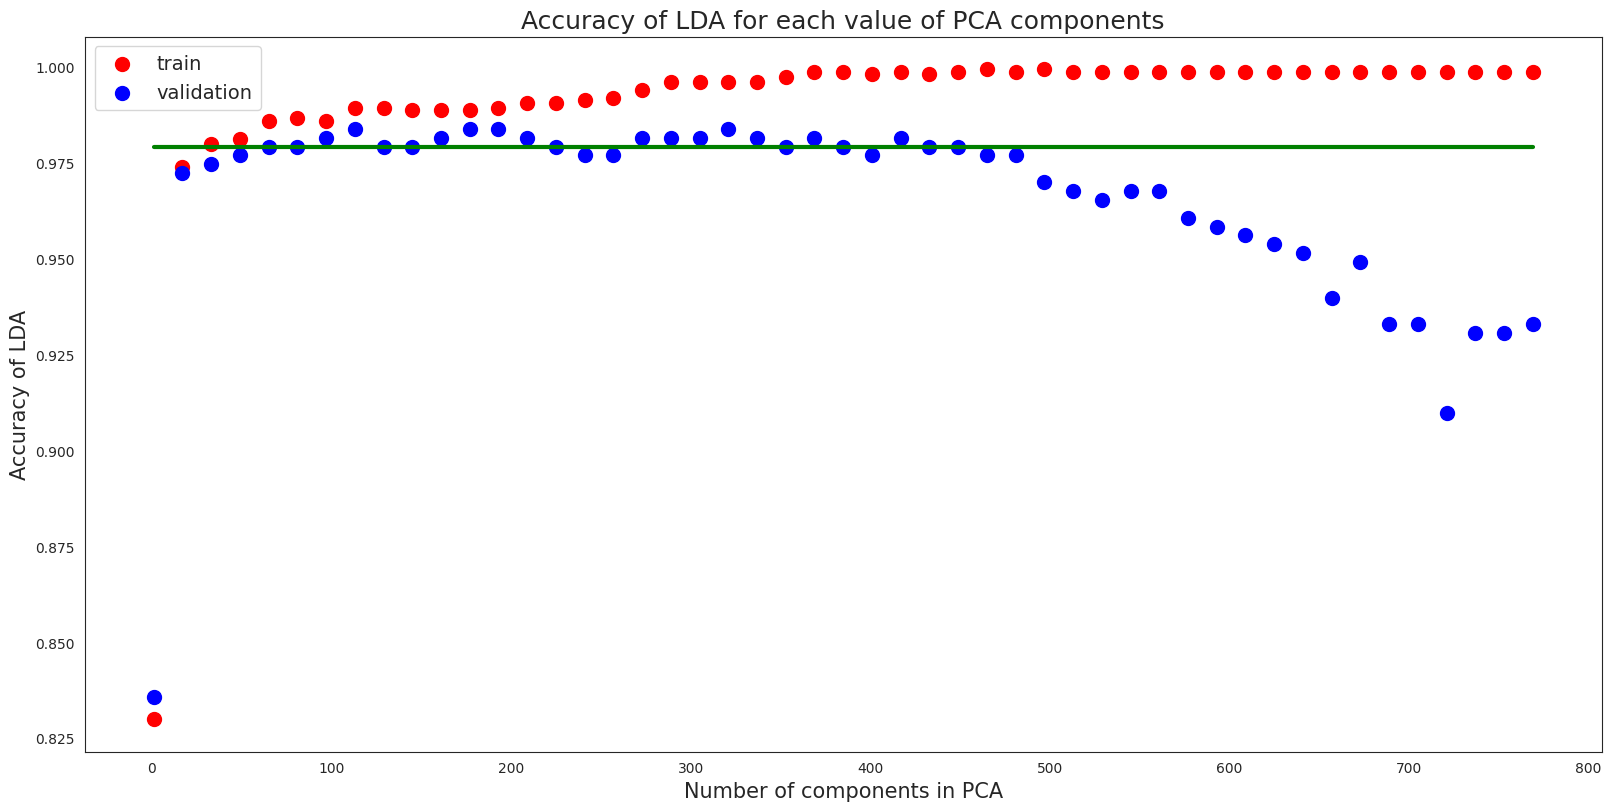

In [64]:
train_acc, val_acc = train_after_PCA(PCAtrain_s, PCAval_s, ytrain, yval, lda, range(1,pca.n_components_,16))
draw_scores_after_PCA (train_acc, val_acc, lda_best_score, range(1,pca.n_components_,16), "Accuracy of LDA for each value of PCA components", "Accuracy of LDA")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The situation with LDA remained completely identical (the same as on the full dataset). In our case, standardization `does not affect the accuracy of LDA`.

Some analysis of PCA on standardized data.

In [65]:
for i in range(10):
    print(f"Variance explained by the {i+1} principal component is {pca.explained_variance_[i]:.2f},\nProportion of the total: {pca.explained_variance_ratio_[i]:.2f},\tCumulative proportion of the total: {pca.explained_variance_ratio_[0:i+1].sum():.2f}")

Variance explained by the 1 principal component is 168.19,
Proportion of the total: 0.22,	Cumulative proportion of the total: 0.22
Variance explained by the 2 principal component is 110.53,
Proportion of the total: 0.14,	Cumulative proportion of the total: 0.36
Variance explained by the 3 principal component is 70.99,
Proportion of the total: 0.09,	Cumulative proportion of the total: 0.45
Variance explained by the 4 principal component is 25.63,
Proportion of the total: 0.03,	Cumulative proportion of the total: 0.48
Variance explained by the 5 principal component is 24.58,
Proportion of the total: 0.03,	Cumulative proportion of the total: 0.51
Variance explained by the 6 principal component is 21.40,
Proportion of the total: 0.03,	Cumulative proportion of the total: 0.54
Variance explained by the 7 principal component is 18.74,
Proportion of the total: 0.02,	Cumulative proportion of the total: 0.56
Variance explained by the 8 principal component is 17.36,
Proportion of the total: 0.02,

In [66]:
cumulative_prop = np.array([])
i = 0
while i < pca.n_components_:
    cumulative_prop = np.append(cumulative_prop, pca.explained_variance_ratio_[0:i+1].sum())
    i += 1
print(f"Amount of principal components, that cover 90% of original data - {np.searchsorted(cumulative_prop, 0.90)}.")
print(f"Amount of principal components, that cover 99% of original data - {np.searchsorted(cumulative_prop, 0.99)}.")

Amount of principal components, that cover 90% of original data - 73.
Amount of principal components, that cover 99% of original data - 292.


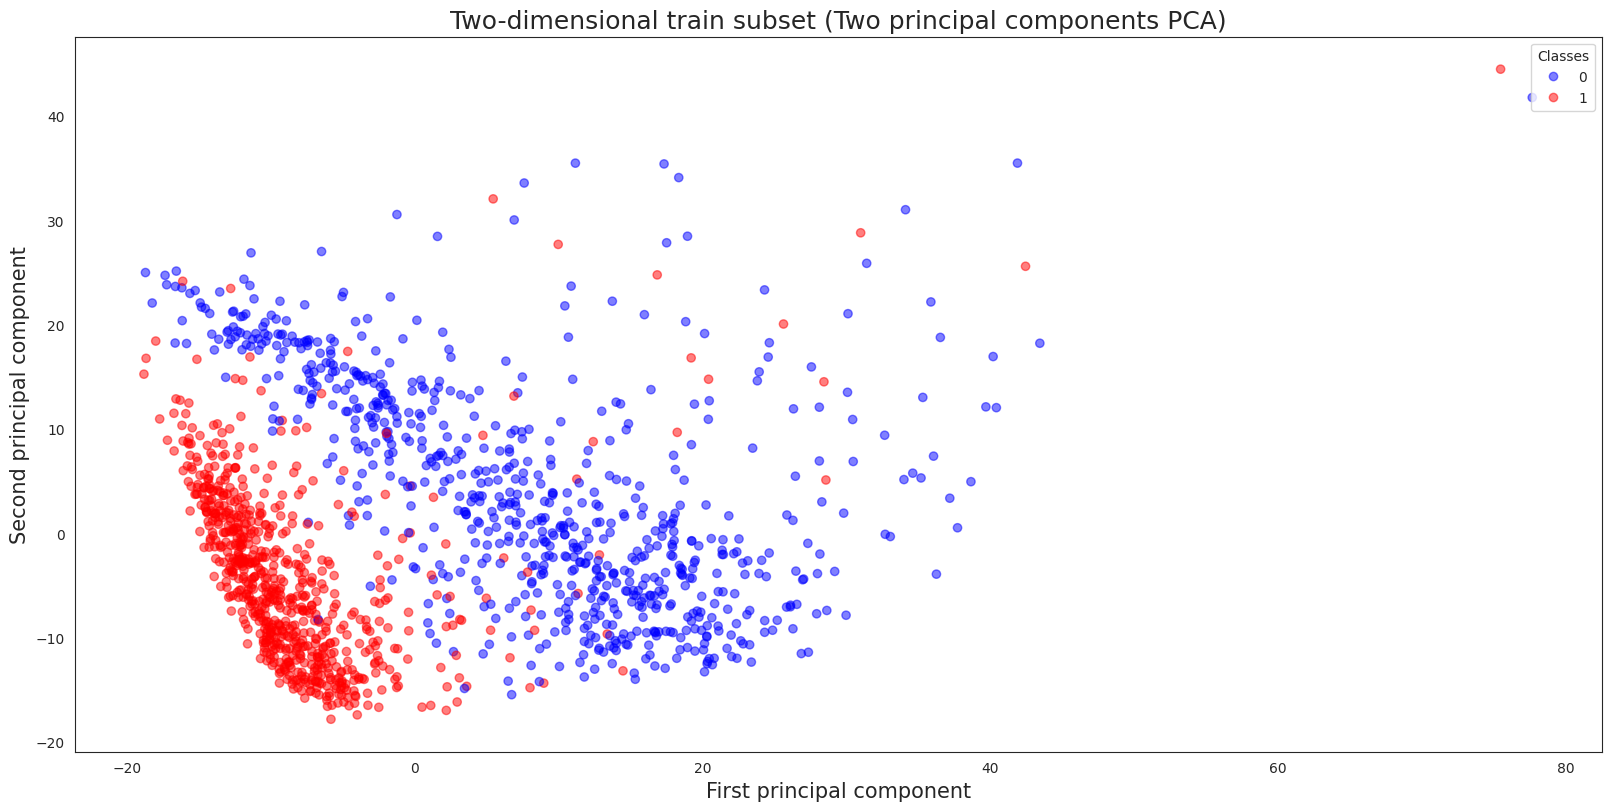

In [67]:
twodim_train_s = PCAtrain_s[:,0:2]
draw_two_dim_graph(twodim_train_s, ytrain, "PCA")

In addition to the change in the measurement scale, the plot is `almost identical to the previous one`.

#### Locally Linear Embedding (LLE)

Unlike **PCA**, **LLE** has an additional parameter `n_neighbors` that can be experimented with. However, considering that for each number of components, LLE needs to be run constantly (unlike **PCA**, where it was enough to run it only once and then take only the number of components you need), the total time it takes to train our models will be `longer than in the case of PCA`. Therefore, we will leave the `n_neighbors` parameter as default to avoid increasing the training time of our models even more.

Other than that, our logic will be similar to what we followed when using PCA. First, we will create two helper functions.

In [68]:
def train_after_LLE(Xtrain, Xval, ytrain, yval, clf, components):
    train_acc = np.array([])
    val_acc = np.array([])

    for am_components in components:
        lle = LocallyLinearEmbedding(n_neighbors=5, n_components=am_components)
        LLEtrain = lle.fit_transform(Xtrain)
        LLEval = lle.transform(Xval)
        clf.fit(LLEtrain, ytrain) 
        train_acc = np.append(train_acc, metrics.accuracy_score(ytrain, clf.predict(LLEtrain)))
        val_acc = np.append(val_acc, metrics.accuracy_score(yval, clf.predict(LLEval)))
    return train_acc, val_acc

In [69]:
def draw_scores_after_LLE (train_acc, val_acc, best_score, components, title, ylabel):
    fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)
    ax.scatter(components, train_acc, s = 100, c="red", label="train")
    ax.scatter(components, val_acc, s = 100, c="blue", label="validation")
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Number of components in LLE", fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.plot([min(components), max(components)], [best_score, best_score],'g-', lw=3)
    ax.legend(fontsize=14)

Starting with **SVM**.

The best accuracy score = 0.98843, amount of components - 17.


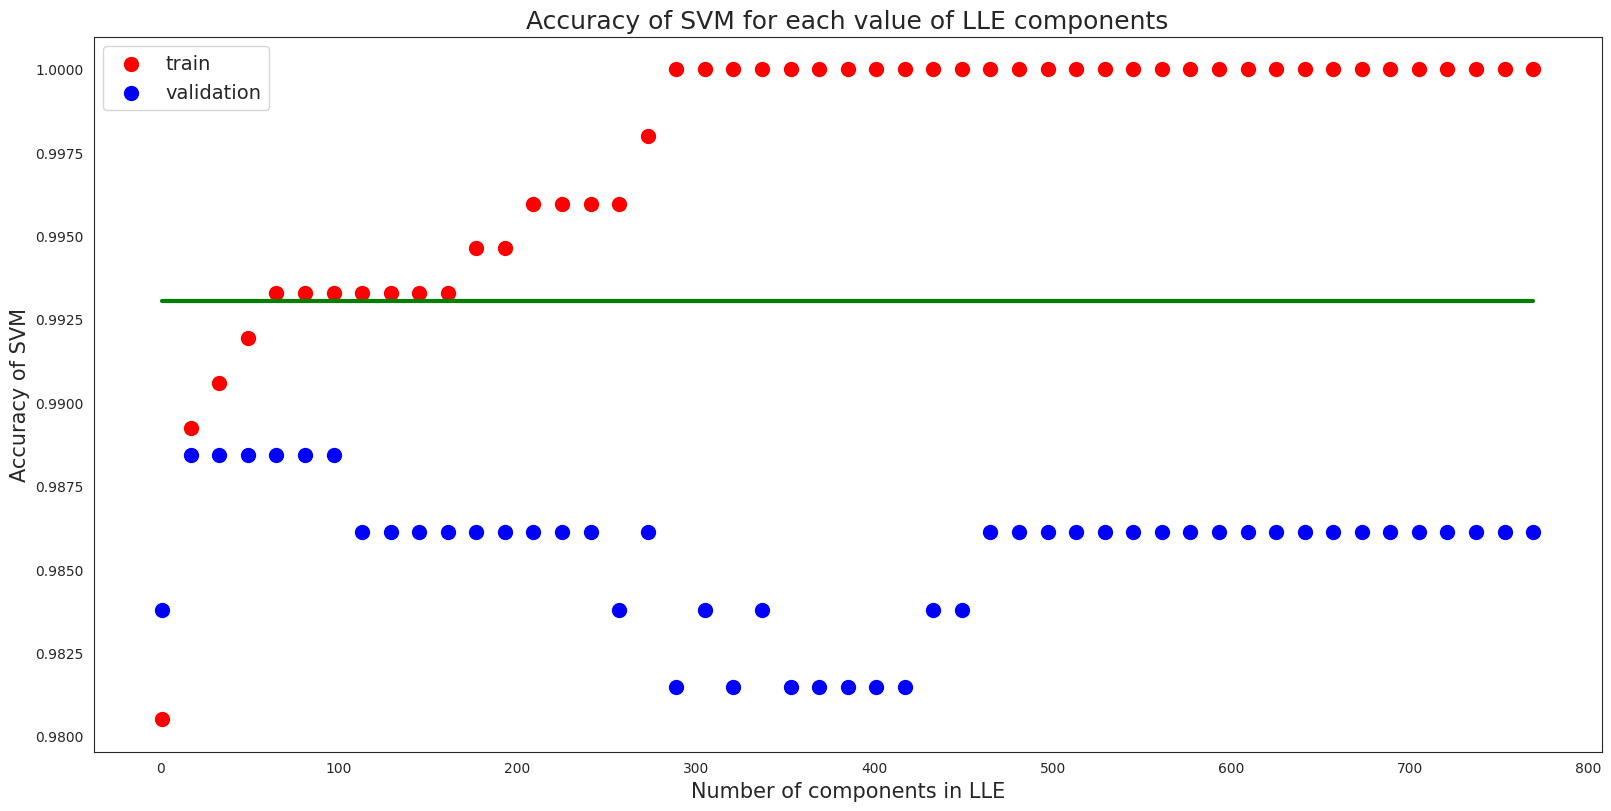

In [70]:
train_acc, val_acc = train_after_LLE(Xtrain, Xval, ytrain, yval, svm, range(1,Xtrain.shape[1],16))
draw_scores_after_LLE(train_acc, val_acc, svm_best_score, range(1,Xtrain.shape[1],16), "Accuracy of SVM for each value of LLE components", "Accuracy of SVM")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The best accuracy score = 0.98843, amount of components - 5.


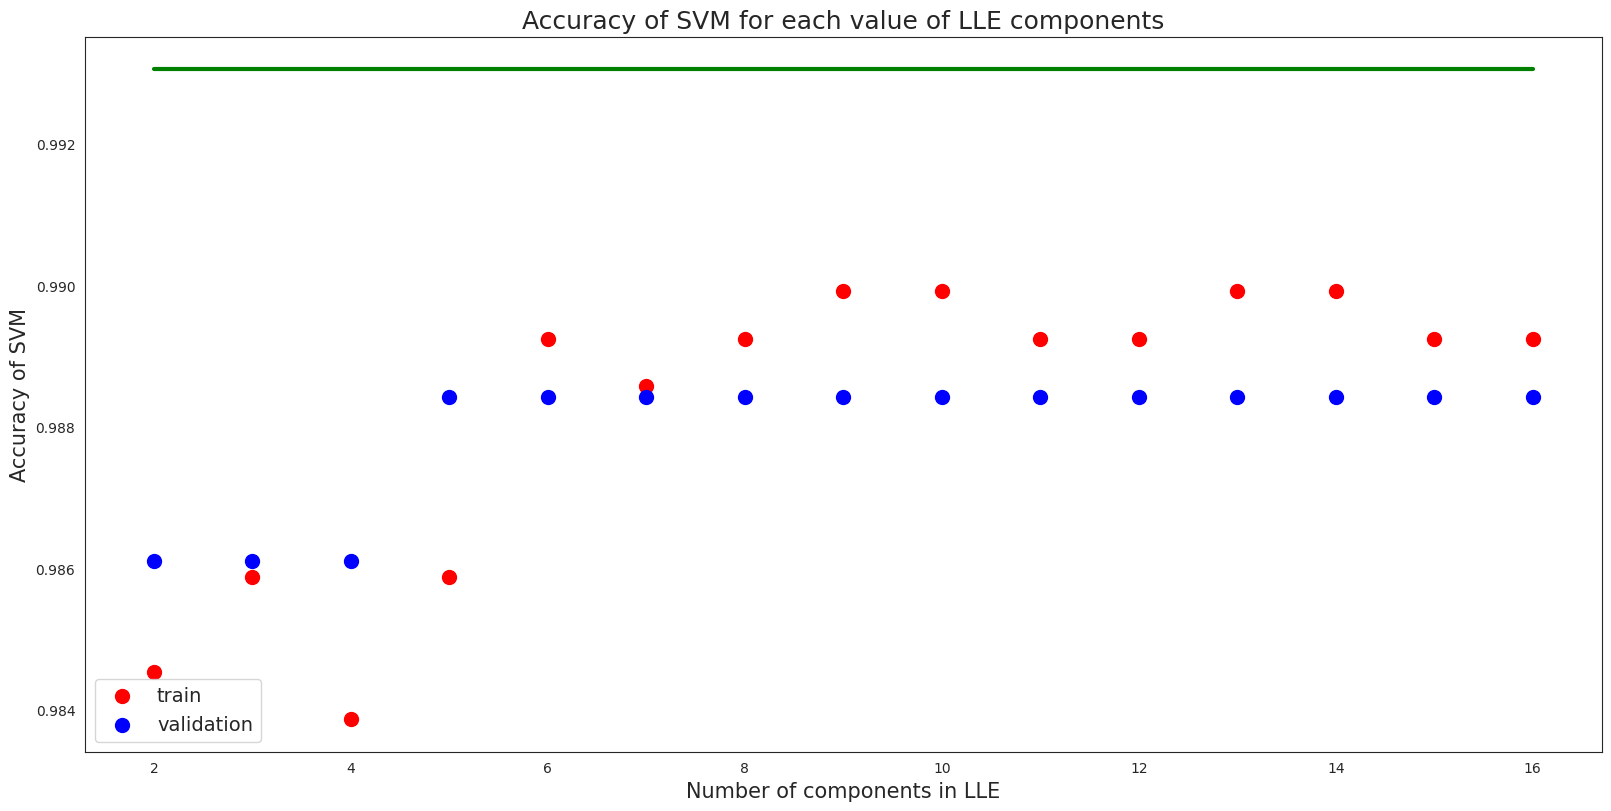

In [71]:
train_acc, val_acc = train_after_LLE(Xtrain, Xval, ytrain, yval, svm, range(2,17))
draw_scores_after_LLE(train_acc, val_acc, svm_best_score, range(2,17), "Accuracy of SVM for each value of LLE components", "Accuracy of SVM")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) + 2}.")

Here, LLE gives us slightly different results than PCA. The accuracy of the model does not remain consistent with increasing number of features - `it decreases` till the values around 300 and after 400 starts increasing. In turn, we achieve the `best accuracy for very low numbers of features`, even higher than in PCA. However, we still cannot achieve the highest accuracy.

Let's draw a plot, that allows us to see our data into `two-dimensional space`.

In [72]:
lle = LocallyLinearEmbedding(n_neighbors=5, n_components=2)
twodim_lle_train = lle.fit_transform(Xtrain)
twodim_lle_val = lle.transform(Xval)
svm.fit(twodim_lle_train, ytrain)
print(f"SVM accuracy on validation data with only two features - {metrics.accuracy_score(yval, svm.predict(twodim_lle_val)):.2f}")

SVM accuracy on validation data with only two features - 0.9861111111111112


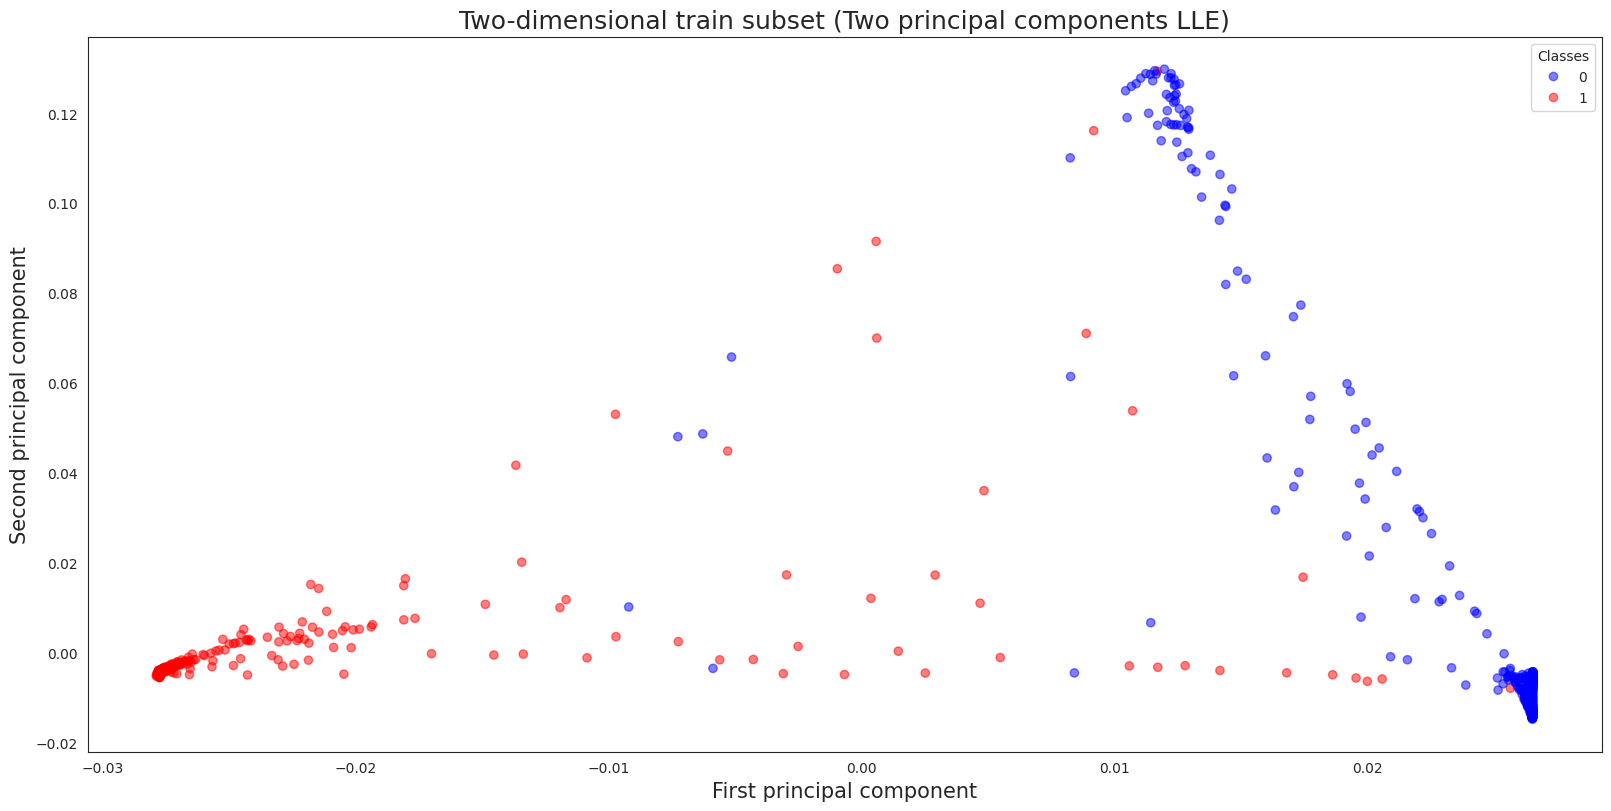

In [73]:
draw_two_dim_graph(twodim_lle_train, ytrain, "LLE")

Moving on to **Naive Bayes**.

The best accuracy score = 0.98611, amount of components - 17.


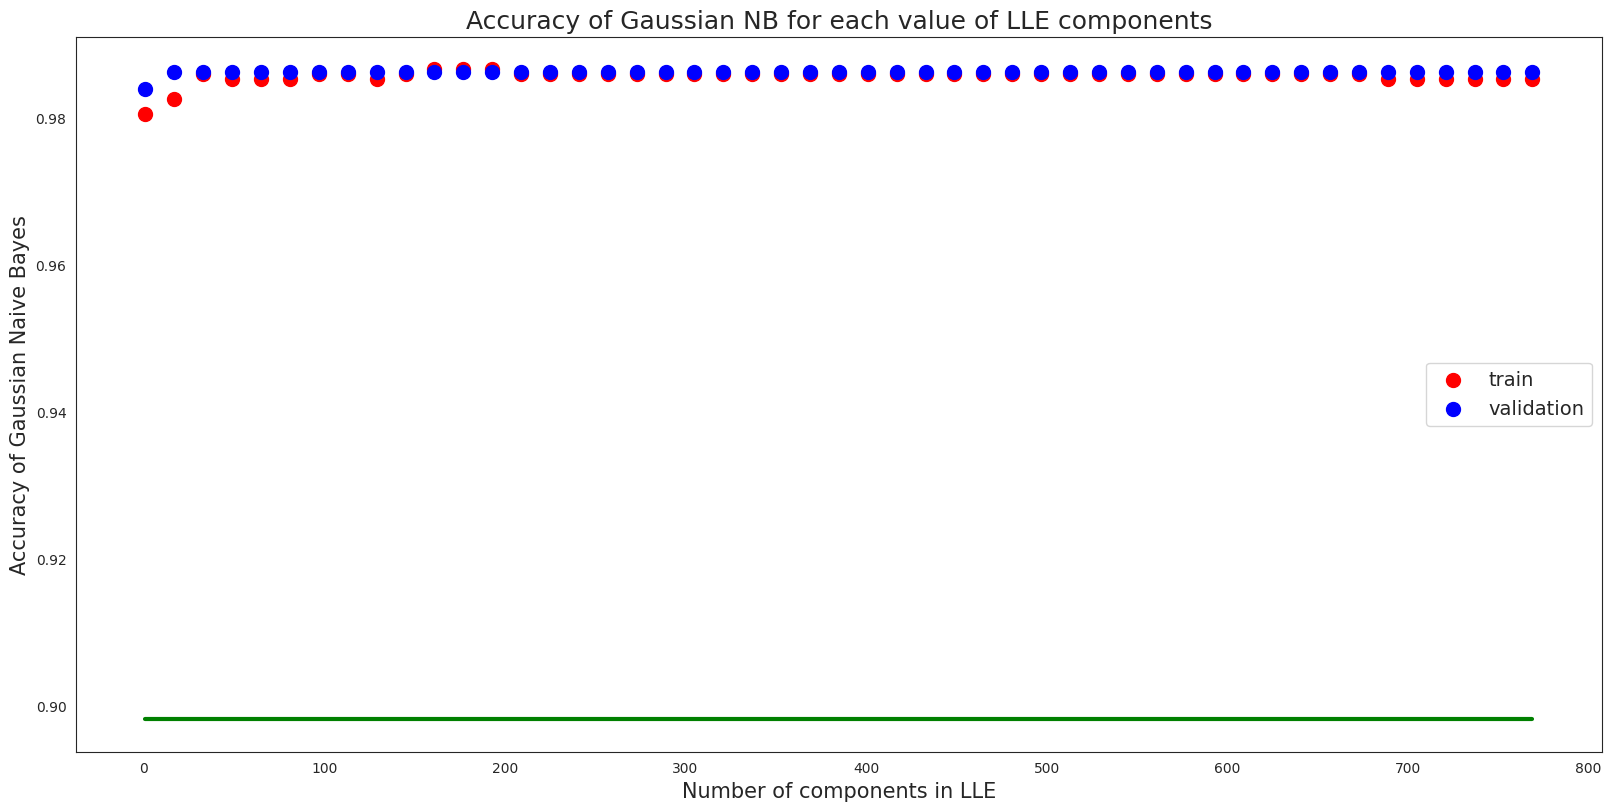

In [74]:
train_acc, val_acc = train_after_LLE(Xtrain, Xval, ytrain, yval, gnb, range(1,Xtrain.shape[1],16))
draw_scores_after_LLE(train_acc, val_acc, gnb_score, range(1,Xtrain.shape[1],16), "Accuracy of Gaussian NB for each value of LLE components", "Accuracy of Gaussian Naive Bayes")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The best accuracy score = 0.98611, amount of components - 13.


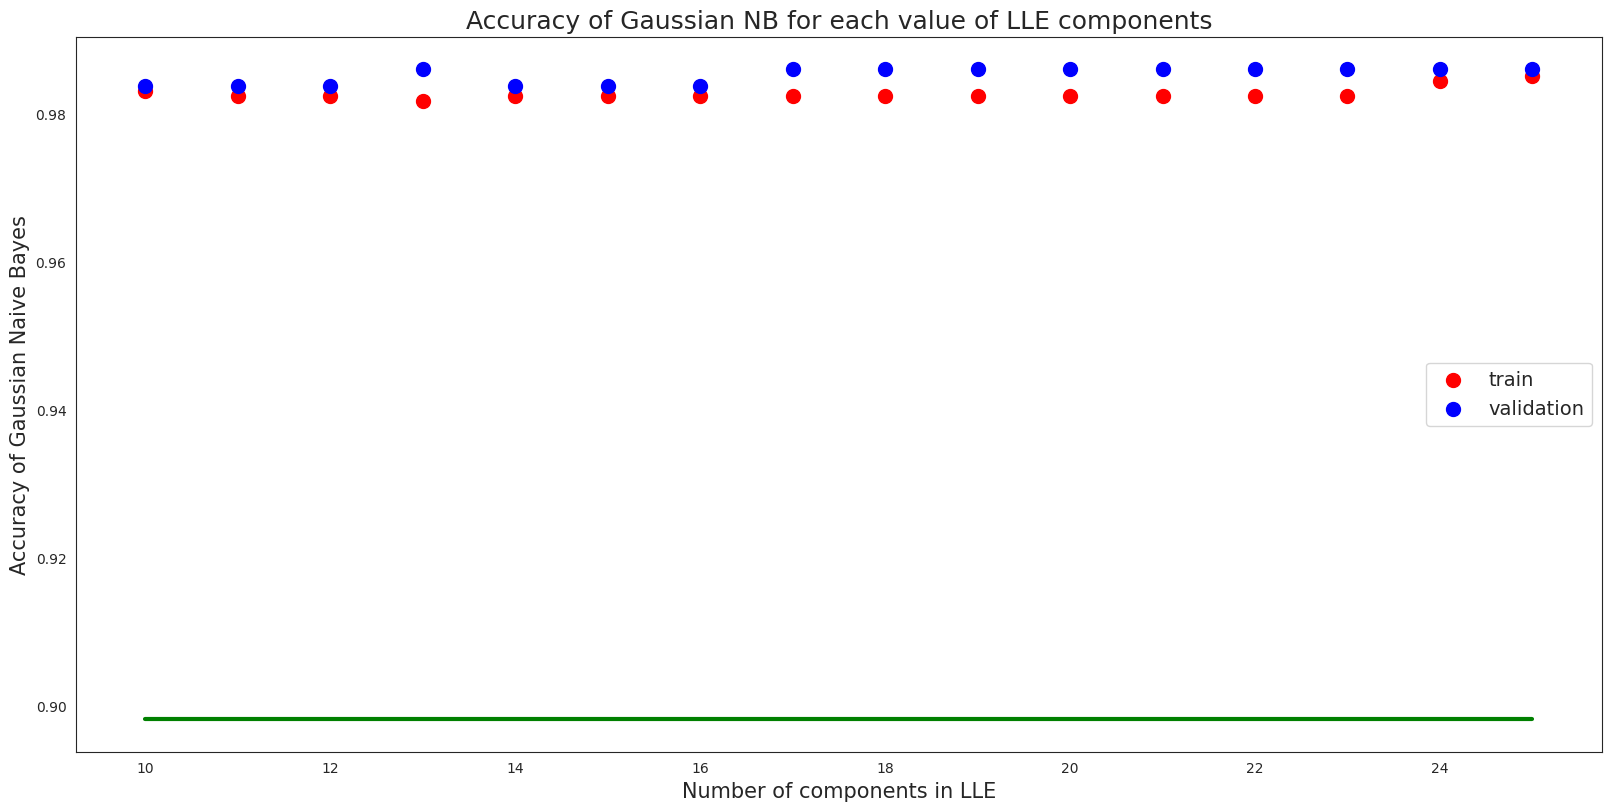

In [75]:
train_acc, val_acc = train_after_LLE(Xtrain, Xval, ytrain, yval, gnb, range(10,26))
draw_scores_after_LLE (train_acc, val_acc, gnb_score, range(10,26), "Accuracy of Gaussian NB for each value of LLE components", "Accuracy of Gaussian Naive Bayes")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) + 10}.")

For **Naive Bayes**, **LLE** gives `the best performance` among all the **Naive Bayeses** we have trained so far (most likely because it managed to solve the problem of data independence). It's interesting that the performance of the model doesn't change with an increase in the number of components, as it was in the case with PCA.

Continue with **LDA**.

The best accuracy score = 0.98843, amount of components - 33.


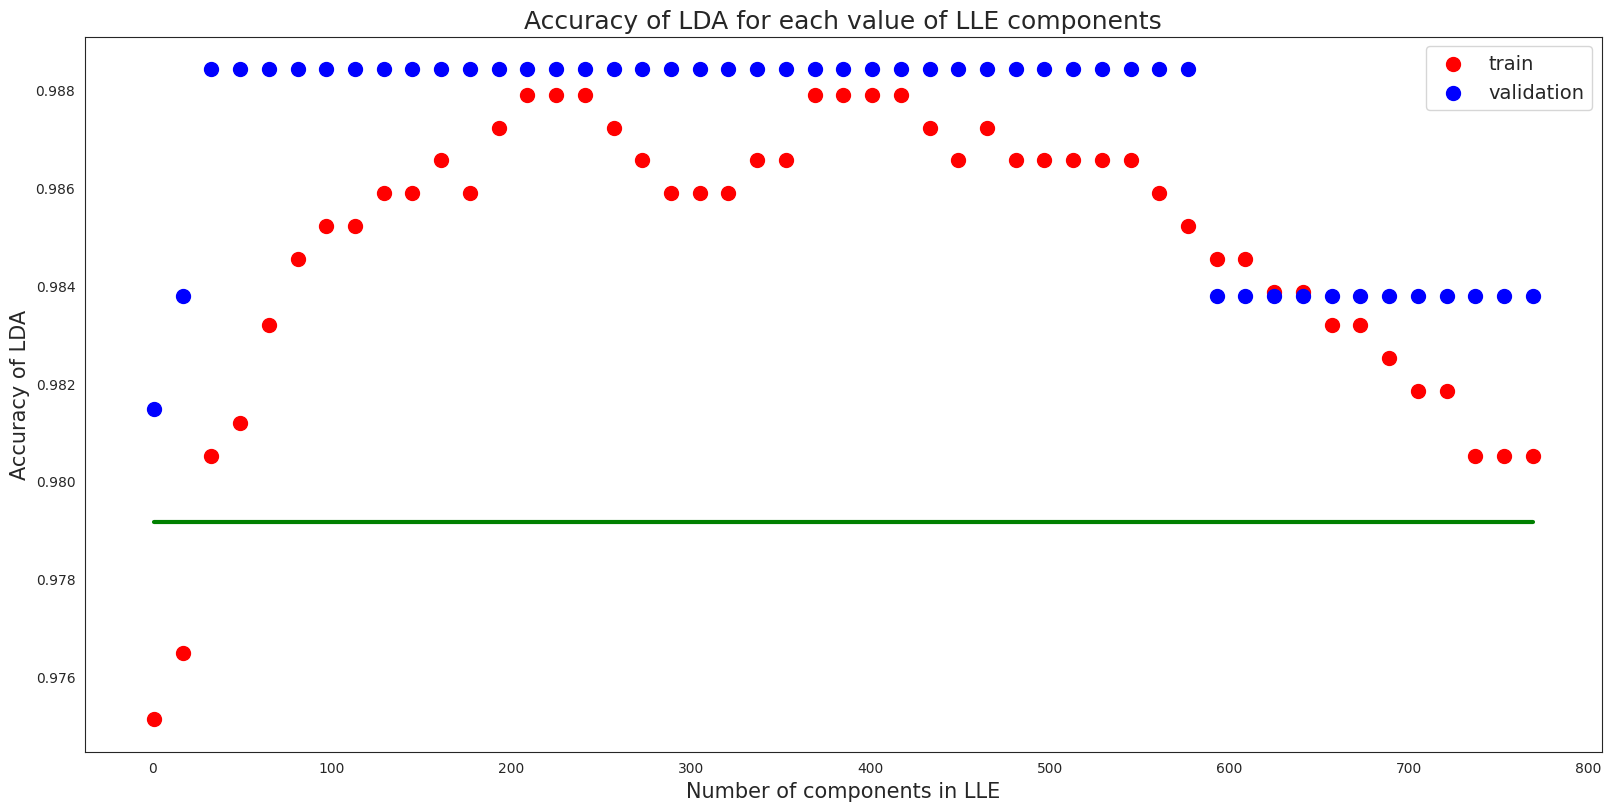

In [76]:
train_acc, val_acc = train_after_LLE(Xtrain, Xval, ytrain, yval, lda, range(1,Xtrain.shape[1],16))
draw_scores_after_LLE (train_acc, val_acc, lda_best_score, range(1,Xtrain.shape[1],16), "Accuracy of LDA for each value of LLE components", "Accuracy of LDA")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The best accuracy score = 0.98843, amount of components - 30.


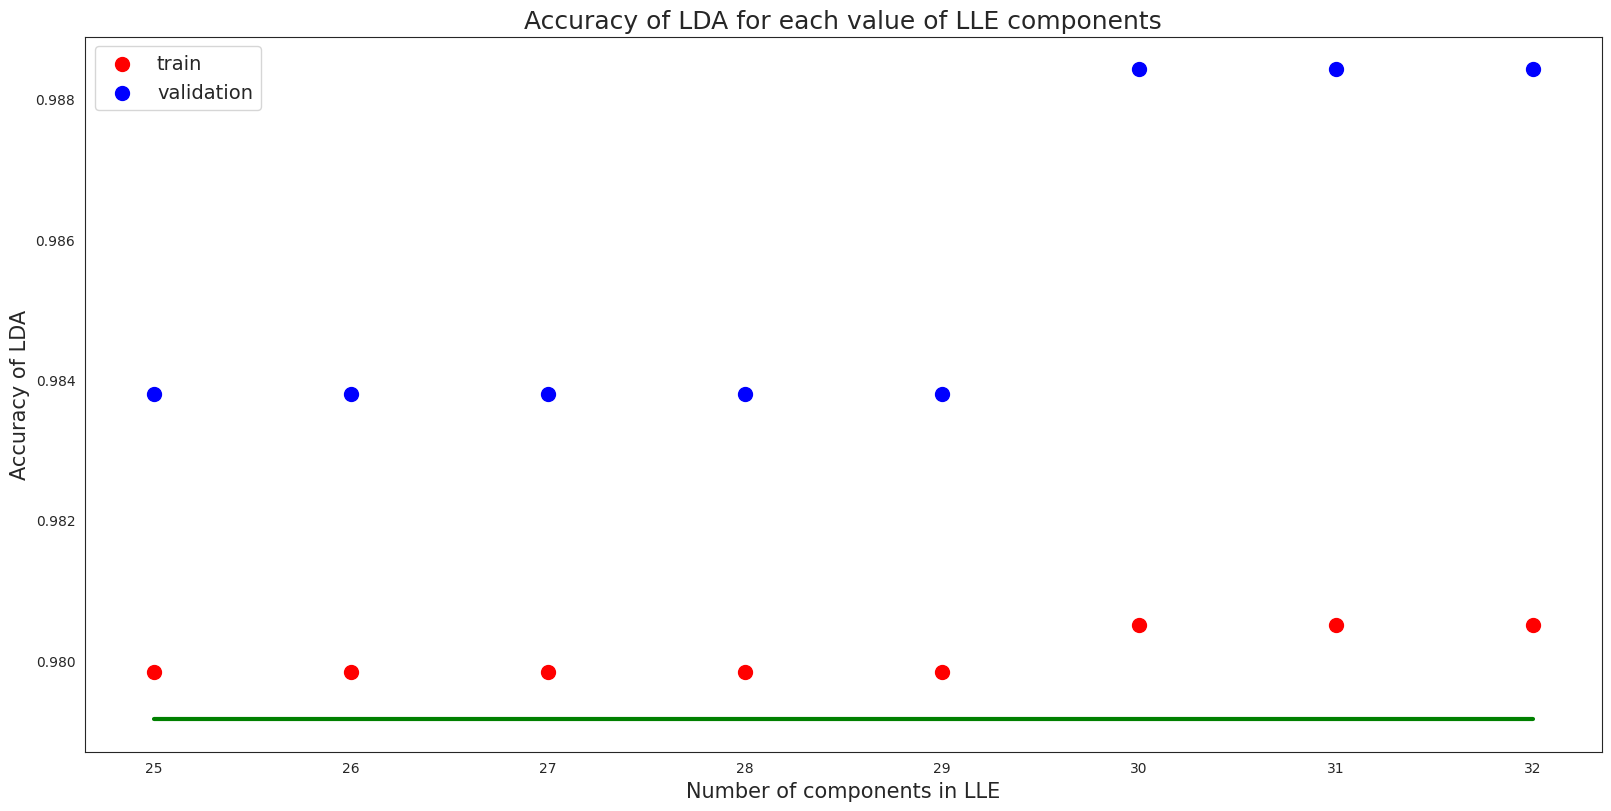

In [77]:
train_acc, val_acc = train_after_LLE(Xtrain, Xval, ytrain, yval, lda, range(25,33))
draw_scores_after_LLE(train_acc, val_acc, lda_best_score, range(25,33), "Accuracy of LDA for each value of LLE components", "Accuracy of LDA")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) + 25}.")

The scatter plot is `quite similar` to what we obtained after PCA, so there's nothing new here that we haven't seen before. The only thing worth noting is that the drop in accuracy happens `abruptly in range around 600 components`.

Now, to make sure that we didn't miss anything, let's `perform LLE on the already standardized data`. If the plots do not differ significantly, I will leave it without comment, because this has been written about many times.

The best accuracy score = 0.98843, amount of components - 33.


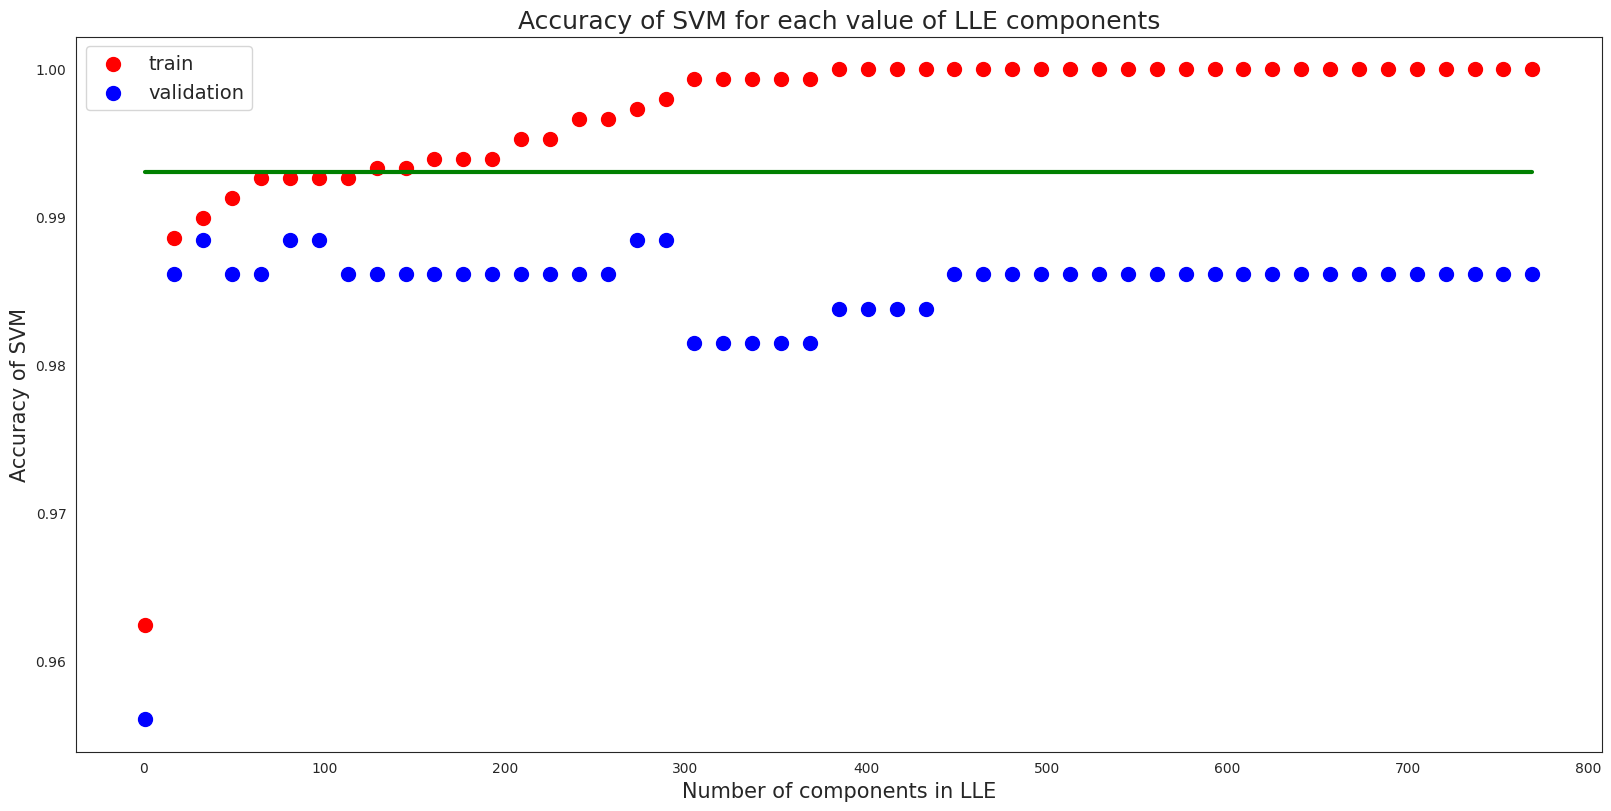

In [78]:
train_acc, val_acc = train_after_LLE(Xtrain_scaled, Xval_scaled, ytrain, yval, svm, range(1,Xtrain_scaled.shape[1],16))
draw_scores_after_LLE(train_acc, val_acc, svm_best_score, range(1,Xtrain_scaled.shape[1],16), "Accuracy of SVM for each value of LLE components", "Accuracy of SVM")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The best accuracy score = 0.98380, amount of components - 65.


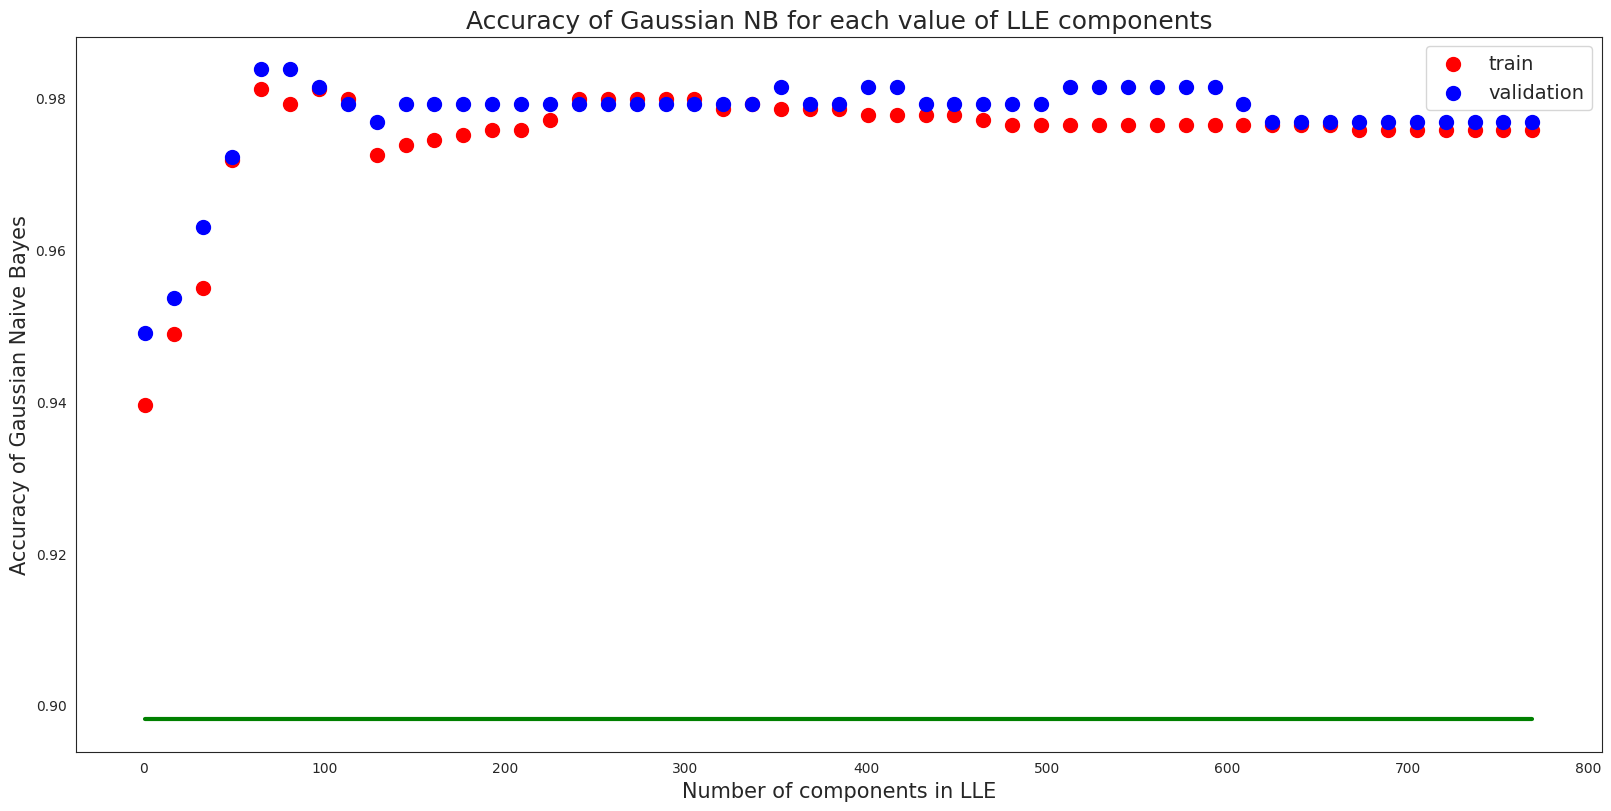

In [79]:
train_acc, val_acc = train_after_LLE(Xtrain_scaled, Xval_scaled, ytrain, yval, gnb, range(1,Xtrain_scaled.shape[1],16))
draw_scores_after_LLE(train_acc, val_acc, gnb_score, range(1,Xtrain_scaled.shape[1],16), "Accuracy of Gaussian NB for each value of LLE components", "Accuracy of Gaussian Naive Bayes")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

The best accuracy score = 0.99074, amount of components - 49.


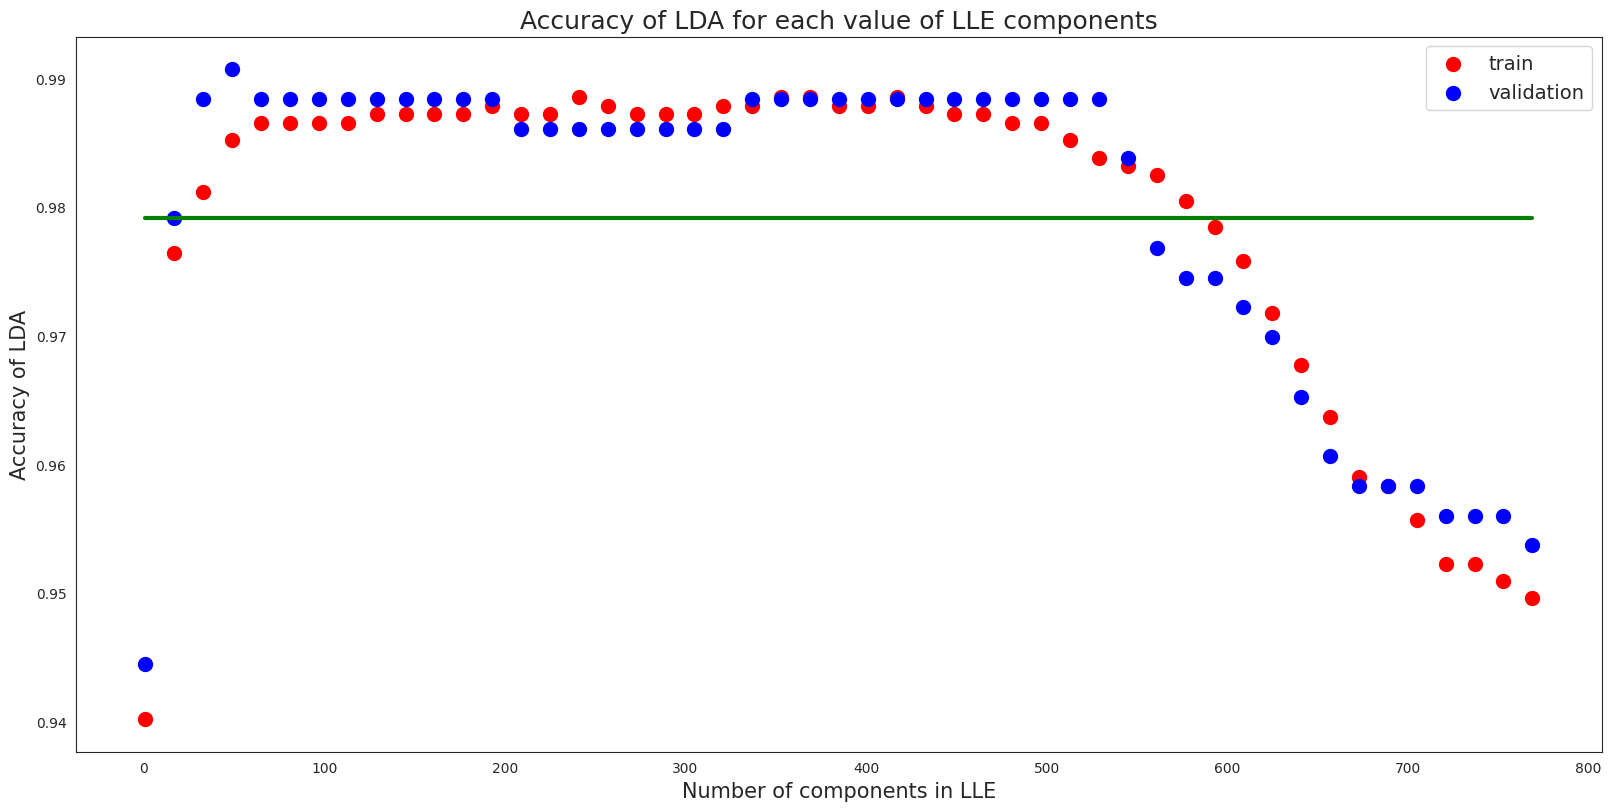

In [80]:
train_acc, val_acc = train_after_LLE(Xtrain_scaled, Xval_scaled, ytrain, yval, lda, range(1,Xtrain_scaled.shape[1],16))
draw_scores_after_LLE (train_acc, val_acc, lda_best_score, range(1,Xtrain_scaled.shape[1],16), "Accuracy of LDA for each value of LLE components", "Accuracy of LDA")

print(f"The best accuracy score = {val_acc.max():.5f}, amount of components - {np.argmax(val_acc) * 16 + 1}.")

From the new:
* The best accuracy on **LDA** model slightly increase, however generally it looks similar.
* For the numbers of components that are lower than 100, accuracy on **Naive Bayes** becomes lower (then it returns to the previous values).

Let's draw a plot, that allows us to see our data into `two-dimensional space`.

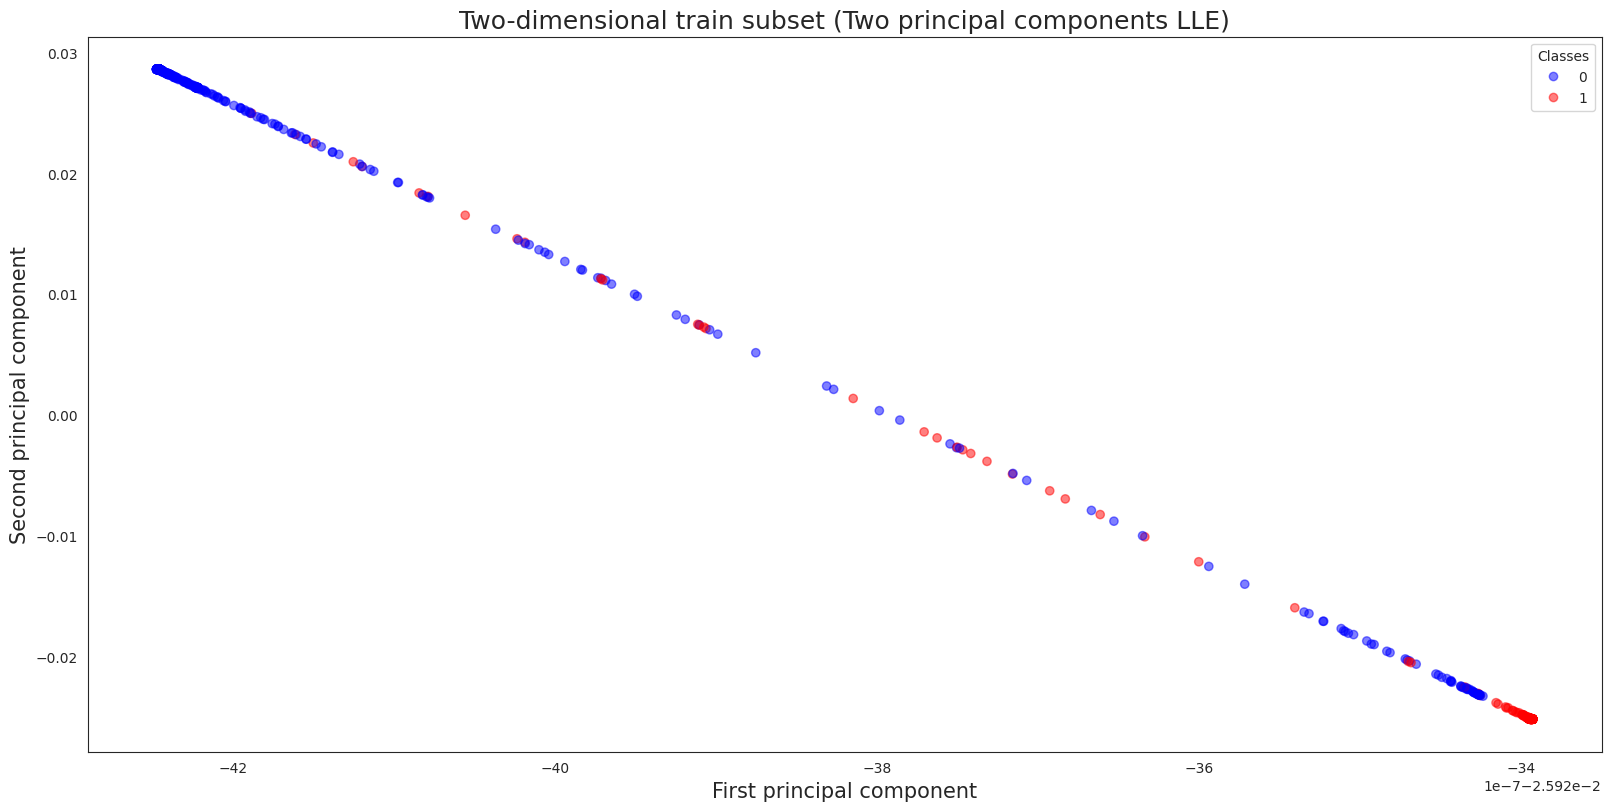

In [81]:
lle = LocallyLinearEmbedding(n_components=2)
twodim_lle_train_s = lle.fit_transform(Xtrain_scaled)
draw_two_dim_graph(twodim_lle_train_s, ytrain, "LLE")

### Final model

So finally we can move on to training the final model. Among all the possible models that we have trained so far, we will `select one` and train it again. After that, we estimate, what `accuracy we can expect on the new data` we have not yet had.

Among all possible models that we trained, **SVM** method almost always gave the `highest accuracy on validation data`, regardless of whether we trained it on the original dataset, standardized data, **PCA**-transformed data, or **LLE**-transformed data (here, **LDA** gave the highest result, but the difference was less than one percent). This is one of the reasons why I paid attention to **SVM**.

If we talk about the highest accuracy among all models, it was again `SVM after PCA with 36 principal components, which was trained on standardized data`. So I decided to give preference to the **SVM** model. Moreover, these are the data transformations that I will use before training **SVM**.

The only thing I don't like is that 36 principal components together do not even cover 90% of the total variance of the dataset, so we will take a number slightly higher than this, but not too much, to avoid `the curse of dimensionality` again (although, as we saw on the graph, the accuracy of **SVM** after **PCA** does not change with the variable number of principal components). From the analysis of **PCA** on standardized data, we saw that around `75 principal components` cover 90% of the variance, so we will `keep that number of principal components` in the final model.

So the final model that I will train is **SVM** after **PCA** with `75 principal components`, run on `standardized data`. We just need to choose hyperparameters for SVM. To do this, we will use the function `find_best_params_SVM()`, which we created earlier.

In [82]:
pca = PCA(n_components=75)
FINtrain = pca.fit_transform(Xtrain_scaled)
FINval = pca.transform(Xval_scaled)
FINtest = pca.transform(Xtest_scaled)

The best pair of hyperparameters has the following values: C - 10.0, kernel - rbf.


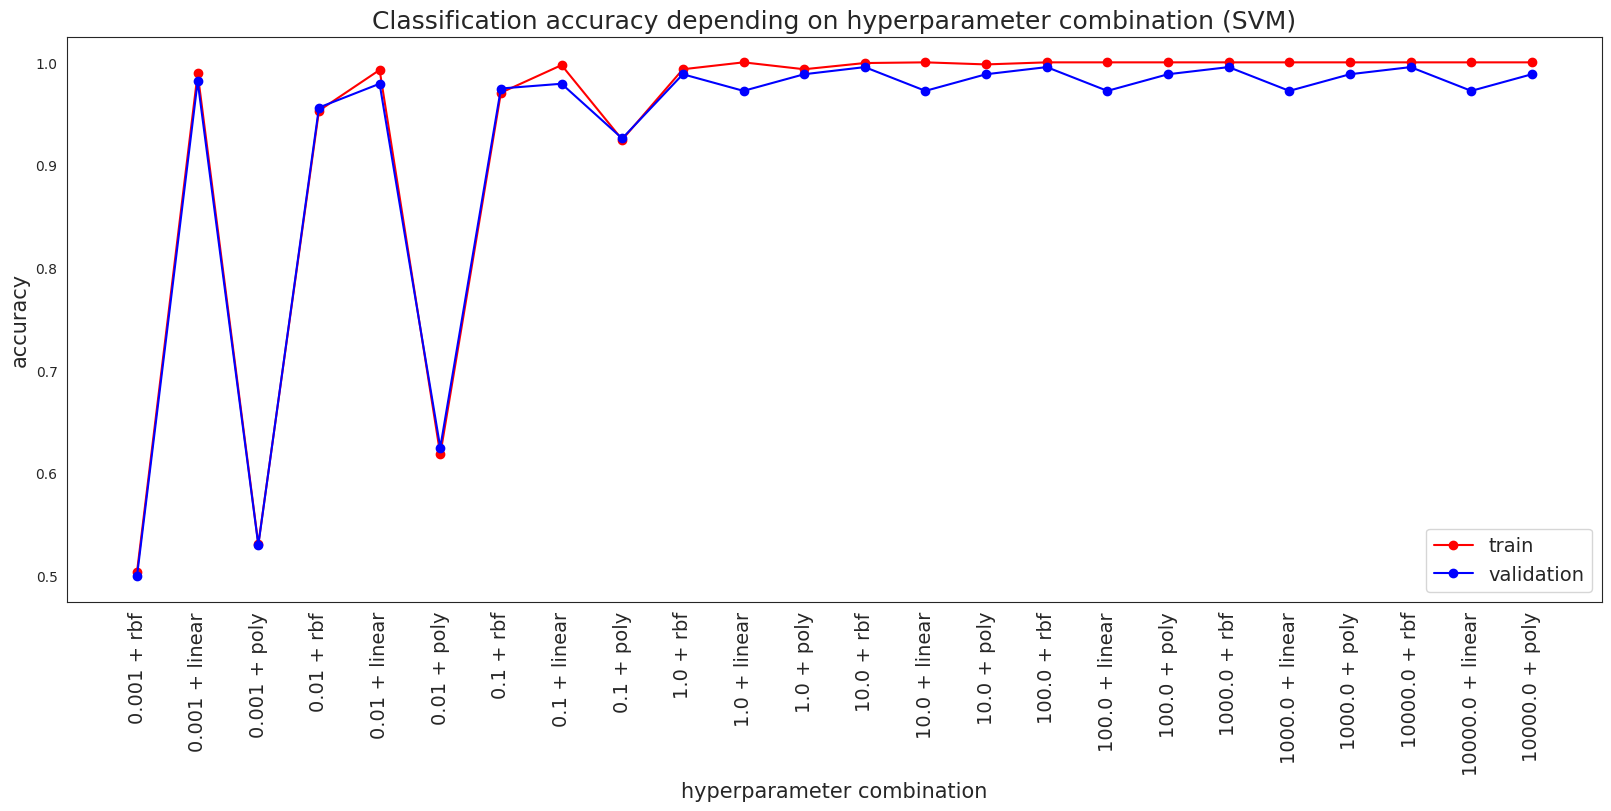

In [83]:
best_params = find_best_params_SVM(FINtrain, ytrain, FINval, yval, param_comb_svm)

In [84]:
svm = SVC(**best_params)
svm.fit(FINtrain, ytrain)
print(f"Accuracy of the model, that we can expect on the new data: {metrics.accuracy_score(ytest,svm.predict(FINtest)):.3f}")

Accuracy of the model, that we can expect on the new data: 0.983


### Predictions for the file evaluation.csv

Let's read data from file **evaluate.csv** and make sure that there are no null values in this data and that all features are of type int64.

In [85]:
evaluation = pd.read_csv("evaluate.csv")

In [86]:
print(f"Data dimensions: {evaluation.shape}")
print(f"Data types of all variables:\n{evaluation.dtypes.value_counts().to_string(index=True, name=False)}")
print(f"Amount of null values in evaluation data - {(len(evaluation.columns[data.isnull().any()]))}")
display(evaluation.head(10))

Data dimensions: (9600, 785)
Data types of all variables:
int64    785
Amount of null values in evaluation data - 0


,ID,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,213,25,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,120,31,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,109,77,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,63,64,75,53,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,113,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,...,103,120,44,0,5,0,0,0,0,0
7,7,0,0,0,0,0,0,0,0,0,...,77,22,0,0,0,0,0,0,0,0
8,8,0,0,0,0,0,0,0,0,0,...,43,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,66,0,0,0,0,0,0,0,0,0


In [87]:
features_ev = evaluation.drop("ID", axis=1)
id_ev = evaluation["ID"]

Transforming data using standartization and PCA.

In [88]:
evaluation_s = scaler.transform(features_ev)
evaluation_pca = pca.transform(evaluation_s)
print(f"Data dimensions after PCA: {evaluation_pca.shape}")

Data dimensions after PCA: (9600, 75)


Predicting results for this data.

In [89]:
results = svm.predict(evaluation_pca)

Let's take a look on predicted data.

In [90]:
print(f"There are {len(set(results))} predicted values: {set(results)}")
print(f"The number of samples that were predicted as zero: {np.count_nonzero(results==0)}.It is {np.count_nonzero(results==0)/len(results)*100:.2f}% of all data from this file.")
print(f"The number of samples that were predicted as one: {np.count_nonzero(results==1)}.It is {np.count_nonzero(results==1)/len(results)*100:.2f}% of all data from this file.")

There are 2 predicted values: {0, 1}
The number of samples that were predicted as zero: 4884.It is 50.88% of all data from this file.
The number of samples that were predicted as one: 4716.It is 49.12% of all data from this file.


Writing the results into a file **results.csv**.

In [91]:
results = pd.Series(results, name="label")
result_df = pd.concat([id_ev, results], axis=1)
result_df.to_csv("results.csv", index=False)

**That's all :)**